In [1]:
# @Author: xie
# @Date:   2025-06-20
# @Email:  xie@umd.edu
# @Last modified by:   xie
# @Last modified time: 2025-06-20
# @License: MIT License

'''
GeoRF_main.py

This file shows an example on how to define, train and evaluate a GeoRF model.
The general usage is similar to standard machine learning models, with fit(), predict() and evaluate() functions.
The main difference is that GeoRF is a spatially-explicit model, which means location info is needed as part of inputs.

Usage:
		There are 4 key steps:
			(1) Data loading: Prepare standard X, y, as well as locations X_loc
			(2) Define groups using GroupGenerator() or by customizing it for your own data: This is needed in GeoRF, which defines the minimum spatial unit for space partitioning.
					For example, a grid can be used to split the study area into groups, where all data points in each grid cell form a group.
					The data may contain thousands of groups, which may be partitioned by GeoRF into 10-20 partitions (one RF per partition). This is just to give a sense of the quantities.
					In testing, the grouping is used to assign test data points to local models (one local RF model is learned for each partition).
			(3) Training: georf.fit()
			(4) Prediction and evaluation: georf.predict() and georf.evaluate()

		For visualizations, code for grid-based grouping is provided. For other group definitions, please write customized visualization functions.
'''

import numpy as np
from scipy import stats
import pandas as pd
import os
import argparse
import sys

#GeoRF
#Can be customized with the template
from GeoRF import GeoRF
from customize import GroupGenerator
from data import load_demo_data#load_data_us_cdl
from helper import get_spatial_range
from initialization import train_test_split_all
#All global parameters
from config import *
from sklearn.impute import SimpleImputer



import polars as pl

data = pl.read_csv(r"C:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\1.Source Data\FEWSNET_IPC_train_lag_forecast_v06252025.csv")
# drop ISO3, fews_ipc_adjusted, fews_proj_med_adjusted, fews_ipc,fews_proj_near, fews_proj_near_ha, fews_proj_med, fews_proj_med_ha, ADMIN0, ADMIN1,ADMIN2,ADMIN3,ISO



In [2]:
data = data.drop(
    [
        "ISO3", "fews_ipc_adjusted", "fews_proj_med_adjusted", "fews_ipc",
        "fews_proj_near", "fews_proj_near_ha", "fews_proj_med",
        "fews_proj_med_ha", "ADMIN0", "ADMIN1", "ADMIN2", "ADMIN3"
    ]
)



# keep only fews_ipc_crisis is not null
data = data.filter(pl.col("fews_ipc_crisis").is_not_null())
# drop unit name, ISO
data = data.drop(["unit_name", "ISO"])
# for AEZ_* replace "False" with 0 and "True" with 1
for col in data.columns:
    if col.startswith("AEZ_"):
        data = data.with_columns(
            pl.when(pl.col(col) == "True")
            .then(1)
            .when(pl.col(col) == "False")
            .then(0)
            .otherwise(pl.col(col))
            .alias(col)
        )
df = data.to_pandas()

X_loc = df[['lat', 'lon']].values



#prepare groups (minimum spatial units for space-partitioning and location groupings, e.g., using a grid)
STEP_SIZE = 0.1
#extract the values of FEWSNET_admin_code and assign to X_group
X_group = df['FEWSNET_admin_code'].values
# convert to integer
X_group = X_group.astype(int)

y = df['fews_ipc_crisis'].values
def train_test_split_by_year(X, y, X_loc, X_group, years, test_year):
  '''Time-based splitting using a date column.

  Parameters
  ----------
  X : array-like
    Feature matrix.
  y : array-like
    Labels.
  X_loc : array-like
    Location information for each sample.
  X_group : array-like
    Group ID for each sample.
  dates : array-like
    1-D array containing a datetime64 dtype or year values.
  test_year : int
    Year used for the test set. All samples with year < test_year form the
    training set and samples with year == test_year form the test set.

  Returns
  -------
  Tuple containing train and test splits in the same format as
  ``train_test_split_all``.
  '''


  # train mask is five years before the test year
  train_mask = (years < test_year) & (years >= (test_year - 5))
  test_mask = years == test_year

  Xtrain = X[train_mask]
  ytrain = y[train_mask]
  Xtrain_loc = X_loc[train_mask]
  Xtrain_group = X_group[train_mask]

  Xtest = X[test_mask]
  ytest = y[test_mask]
  Xtest_loc = X_loc[test_mask]
  Xtest_group = X_group[test_mask]


  return Xtrain, ytrain, Xtrain_loc, Xtrain_group, Xtest, ytest, Xtest_loc, Xtest_group

#X impute with column mean


df['date'] = pd.to_datetime(df['date'])
df['years'] = df['date'].dt.year

# sort by FEWSNET_admin_code and date
df = df.sort_values(by=['FEWSNET_admin_code', 'date'])
# for each FEWSNET_admin_code, created lagged fews_ipc_crisis for 1,2 and 3 terms
for lag in range(1, 4):
    df[f'fews_ipc_crisis_lag_{lag}'] = df.groupby('FEWSNET_admin_code')['fews_ipc_crisis'].shift(lag)
# drop date
df = df.drop(columns=['date'])


In [3]:
time_variants =  ['event_count_battles', 'event_count_explosions', 'event_count_violence', 'sum_fatalities_battles', 'sum_fatalities_explosions', 'sum_fatalities_violence', 'event_count_battles_w5', 'event_count_explosions_w5', 'event_count_violence_w5', 'sum_fatalities_battles_w5', 'sum_fatalities_explosions_w5', 'sum_fatalities_violence_w5', 'event_count_battles_w10', 'event_count_explosions_w10', 'event_count_violence_w10', 'sum_fatalities_battles_w10', 'sum_fatalities_explosions_w10', 'sum_fatalities_violence_w10', 'nightlight', 'nightlight_sd', 'EVI', 'EVI_stdDev',  'FAO_price', 'Evap_tavg_mean', 'Evap_tavg_stdDev', 'LWdown_f_tavg_mean', 'LWdown_f_tavg_stdDev', 'Lwnet_tavg_mean', 'Lwnet_tavg_stdDev', 'Psurf_f_tavg_mean', 'Psurf_f_tavg_stdDev', 'Qair_f_tavg_mean', 'Qair_f_tavg_stdDev', 'Qg_tavg_mean', 'Qg_tavg_stdDev', 'Qh_tavg_mean', 'Qh_tavg_stdDev', 'Qle_tavg_mean', 'Qle_tavg_stdDev', 'Qs_tavg_mean', 'Qs_tavg_stdDev', 'Qsb_tavg_mean', 'Qsb_tavg_stdDev', 'RadT_tavg_mean', 'RadT_tavg_stdDev', 'Rainf_f_tavg_mean', 'Rainf_f_tavg_stdDev', 'SnowCover_inst_mean', 'SnowCover_inst_stdDev', 'SnowDepth_inst_mean', 'SnowDepth_inst_stdDev', 'Snowf_tavg_mean', 'Snowf_tavg_stdDev', 'SoilMoi00_10cm_tavg_mean', 'SoilMoi00_10cm_tavg_stdDev', 'SoilMoi10_40cm_tavg_mean', 'SoilMoi10_40cm_tavg_stdDev', 'SoilMoi100_200cm_tavg_mean', 'SoilMoi100_200cm_tavg_stdDev', 'SoilMoi40_100cm_tavg_mean', 'SoilMoi40_100cm_tavg_stdDev', 'SoilTemp00_10cm_tavg_mean', 'SoilTemp00_10cm_tavg_stdDev', 'SoilTemp10_40cm_tavg_mean', 'SoilTemp10_40cm_tavg_stdDev', 'SoilTemp100_200cm_tavg_mean', 'SoilTemp100_200cm_tavg_stdDev', 'SoilTemp40_100cm_tavg_mean', 'SoilTemp40_100cm_tavg_stdDev', 'SWdown_f_tavg_mean', 'SWdown_f_tavg_stdDev', 'SWE_inst_mean', 'SWE_inst_stdDev', 'Swnet_tavg_mean', 'Swnet_tavg_stdDev', 'Tair_f_tavg_mean', 'Tair_f_tavg_stdDev', 'Wind_f_tavg_mean', 'Wind_f_tavg_stdDev', 'gpp_sd', 'gpp_mean', 'CPI', 'GDP', 'CC', 'gini', 'WFP_Price', 'WFP_Price_std']

In [4]:
#delete every column in the time_variants, for columns not shown in df, skip
for col in time_variants:
    if col in df.columns:
        df = df.drop(columns=[col])

In [5]:
#delete every column ended with m12
df = df.drop(columns=[col for col in df.columns if col.endswith('_m12')])

In [6]:

# simple imputer for missing values
X = df.drop(columns=['fews_ipc_crisis', 'lat', 'lon']).values


In [ ]:
xmin

In [ ]:
xmax

In [ ]:
ymin

In [ ]:
ymax

In [7]:
# loop over X columns, replace inf with missing
for _ in range(X.shape[1]):
    print(f"Checking column {_} for inf values")
    # Try to convert column to float, ignore errors (non-convertible values remain unchanged)
    col_data = X[:, _]
    try:
        col_data_float = col_data.astype(float)
        if np.isinf(col_data_float).any():
            print(f"Column {_} has inf values, replacing with NaN")
            col_data_float[np.isinf(col_data_float)] = np.nan
            X[:, _] = col_data_float
    except Exception as e:
        print(f"Column {_} could not be converted to float: {e}")
        # Skip columns that cannot be converted
        continue

Checking column 0 for inf values
Checking column 1 for inf values
Checking column 2 for inf values
Checking column 3 for inf values
Checking column 4 for inf values
Checking column 5 for inf values
Checking column 6 for inf values
Checking column 7 for inf values
Checking column 8 for inf values
Checking column 9 for inf values
Checking column 10 for inf values
Checking column 11 for inf values
Checking column 12 for inf values
Checking column 13 for inf values
Checking column 14 for inf values
Checking column 15 for inf values
Checking column 16 for inf values
Checking column 17 for inf values
Checking column 18 for inf values
Checking column 19 for inf values
Checking column 20 for inf values
Checking column 21 for inf values
Checking column 22 for inf values
Checking column 23 for inf values
Checking column 24 for inf values
Checking column 25 for inf values
Checking column 26 for inf values
Checking column 27 for inf values
Checking column 28 for inf values
Checking column 29 for i

In [8]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')    
# loop over X columns and impute missing values
for _ in range(X.shape[1]):
    print(f"Imputing column {_} with mean")
    X[:, _] = imputer.fit_transform(X[:, _].reshape(-1, 1)).ravel()

Imputing column 0 with mean
Imputing column 1 with mean
Imputing column 2 with mean
Imputing column 3 with mean
Imputing column 4 with mean
Imputing column 5 with mean
Imputing column 6 with mean
Imputing column 7 with mean
Imputing column 8 with mean
Imputing column 9 with mean
Imputing column 10 with mean
Imputing column 11 with mean
Imputing column 12 with mean
Imputing column 13 with mean
Imputing column 14 with mean
Imputing column 15 with mean
Imputing column 16 with mean
Imputing column 17 with mean
Imputing column 18 with mean
Imputing column 19 with mean
Imputing column 20 with mean
Imputing column 21 with mean
Imputing column 22 with mean
Imputing column 23 with mean
Imputing column 24 with mean
Imputing column 25 with mean
Imputing column 26 with mean
Imputing column 27 with mean
Imputing column 28 with mean
Imputing column 29 with mean
Imputing column 30 with mean
Imputing column 31 with mean
Imputing column 32 with mean
Imputing column 33 with mean
Imputing column 34 with 

model_dir: result_GeoRF_37


c:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\STAR\Tree-based-models\helper.py:235: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s_branch[''][:gid_list.shape[0]] = gid_list
c:\Users\swl00\IFPR

model_dir: result_GeoRF_37
Printing to file.


C:\Users\swl00\AppData\Local\Temp\ipykernel_29084\4240989571.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'year': year,'precision':pre[1] , 'recall': rec[1], 'f1': f1[1], 'precision_base': pre_base[1], 'recall_base': rec_base[1], 'f1_base': f1_base[1]}, index=[0])],ignore_index=True)
C:\Users\swl00\AppData\Local\Temp\ipykernel_29084\4240989571.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  y_pred_test = pd.concat([y_pred_test, pd.Da

model_dir: result_GeoRF_38


c:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\STAR\Tree-based-models\helper.py:235: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s_branch[''][:gid_list.shape[0]] = gid_list
c:\Users\swl00\IFPR

model_dir: result_GeoRF_38
Printing to file.
model_dir: result_GeoRF_39


c:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\STAR\Tree-based-models\helper.py:235: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s_branch[''][:gid_list.shape[0]] = gid_list
c:\Users\swl00\IFPR

model_dir: result_GeoRF_39
Printing to file.
model_dir: result_GeoRF_40


c:\Users\swl00\IFPRI Dropbox\Weilun Shi\Google fund\Analysis\2.source_code\Step5_Geo_RF_trial\STAR\Tree-based-models\helper.py:235: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s_branch[''][:gid_list.shape[0]] = gid_list
c:\Users\swl00\IFPR

model_dir: result_GeoRF_40
Printing to file.


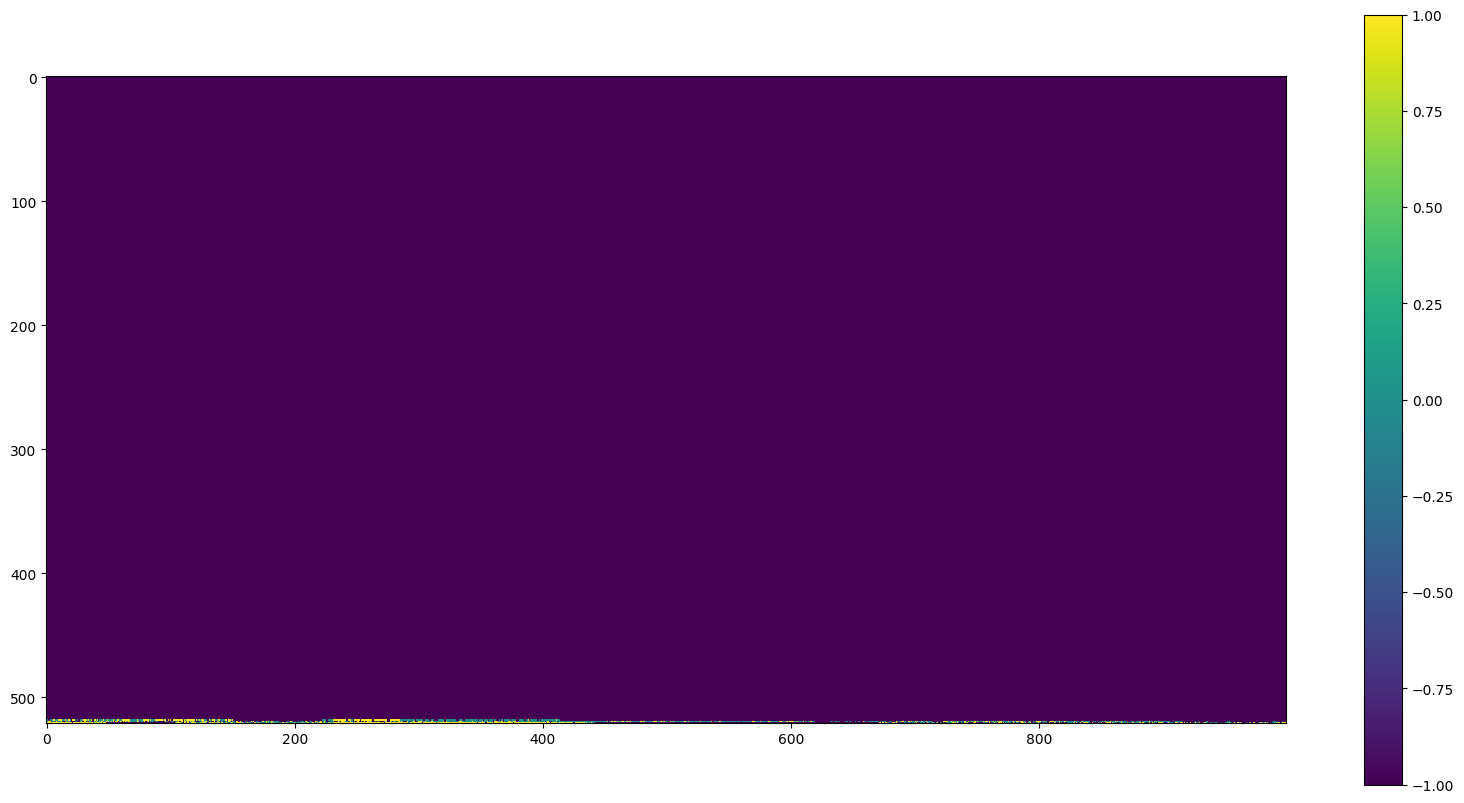

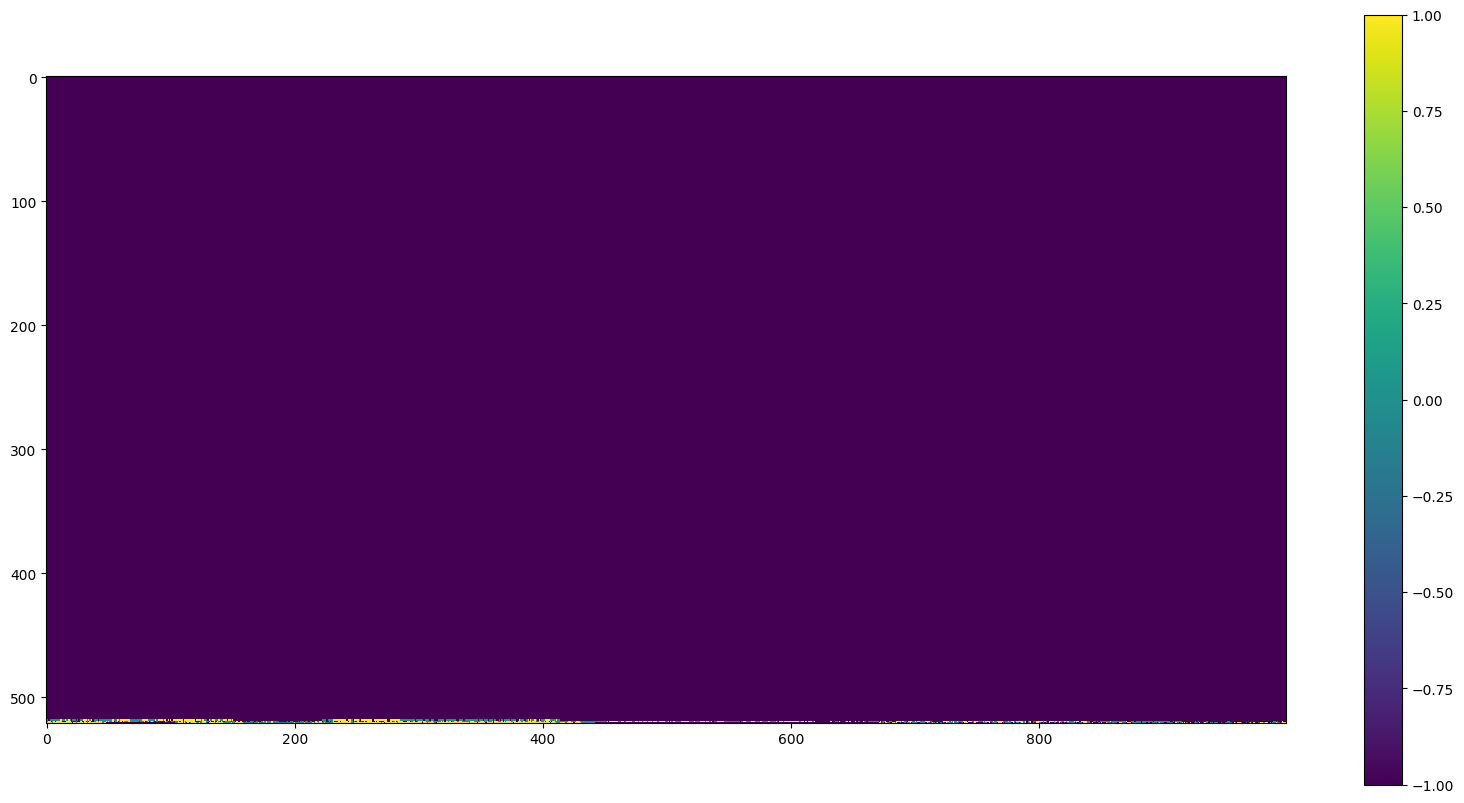

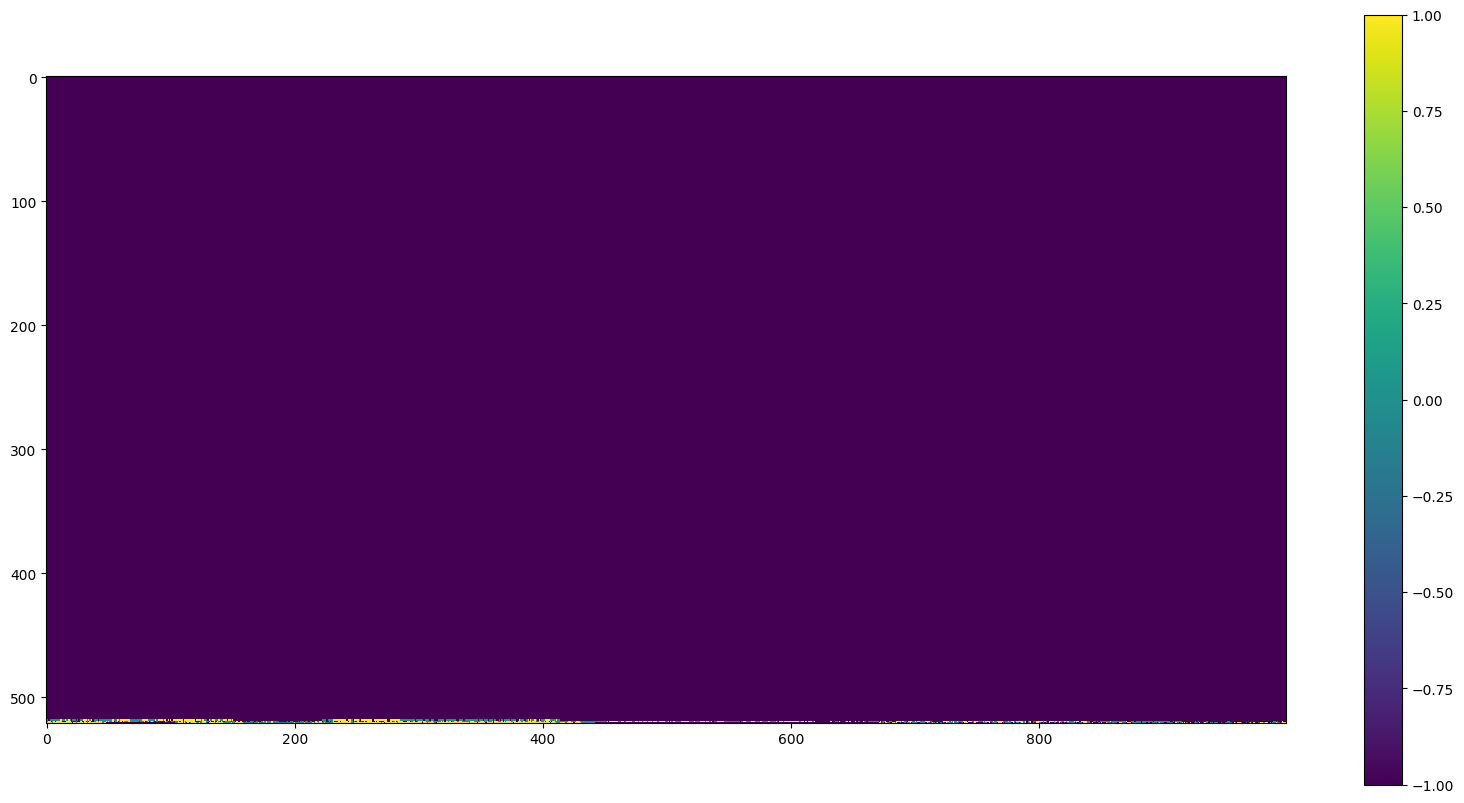

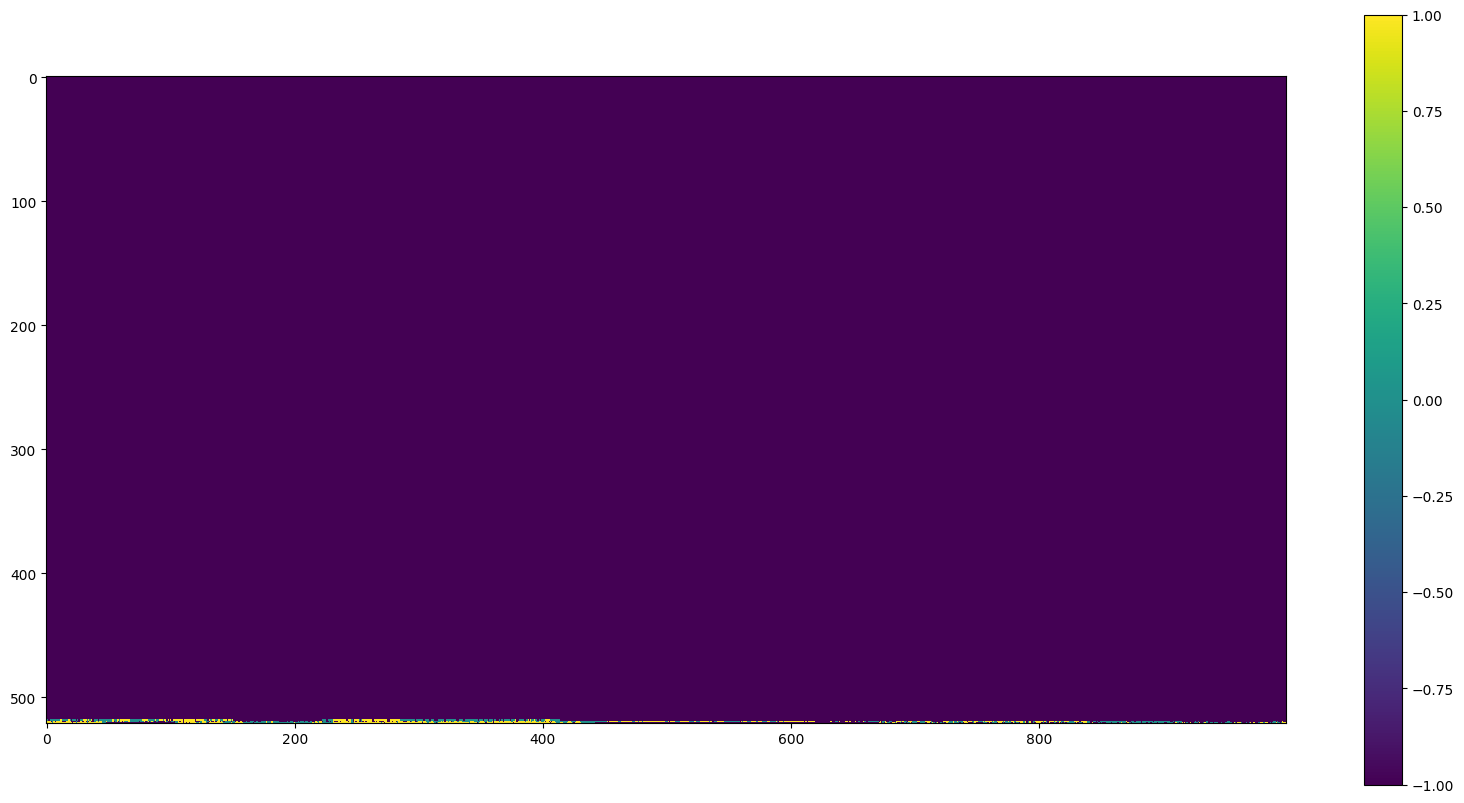

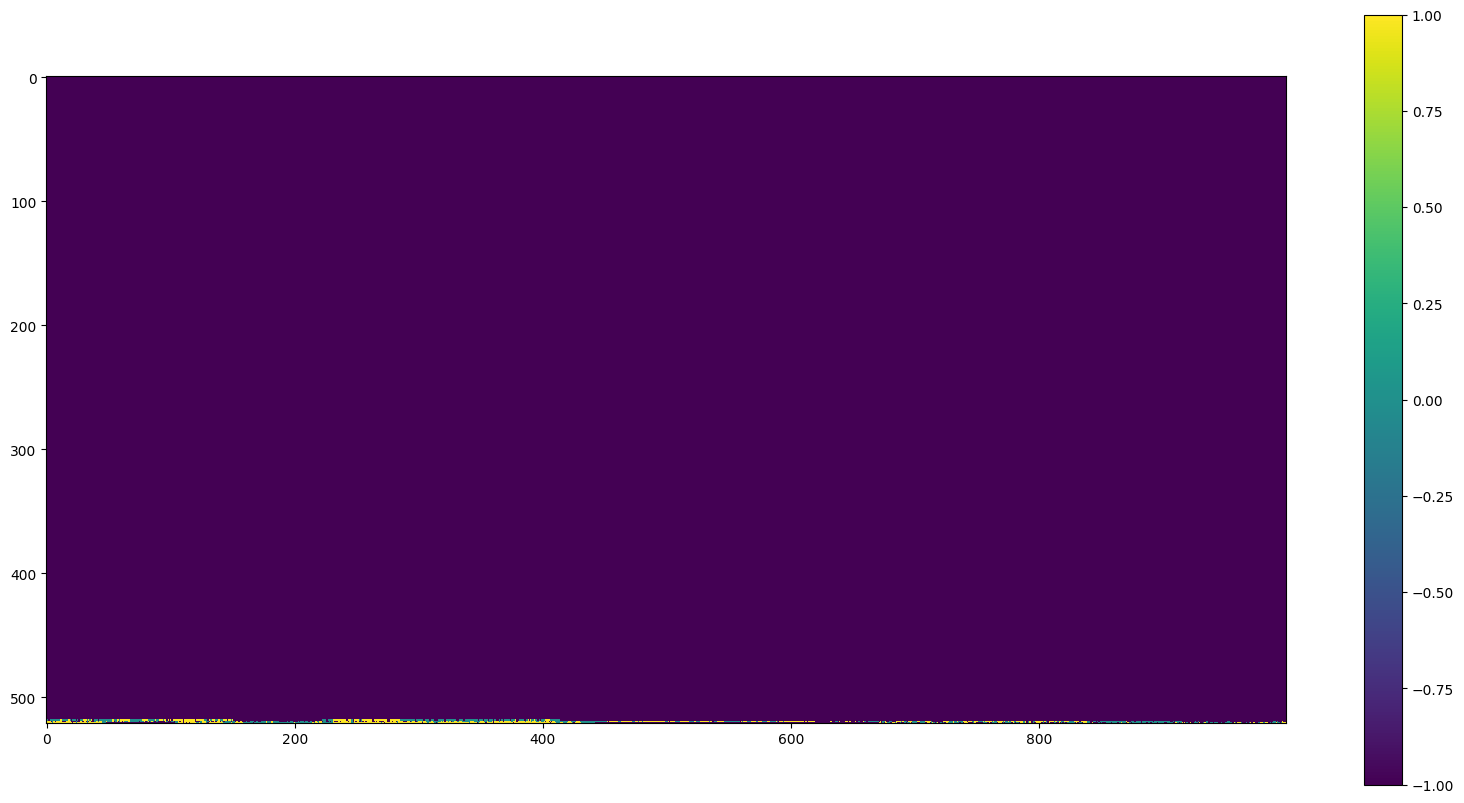

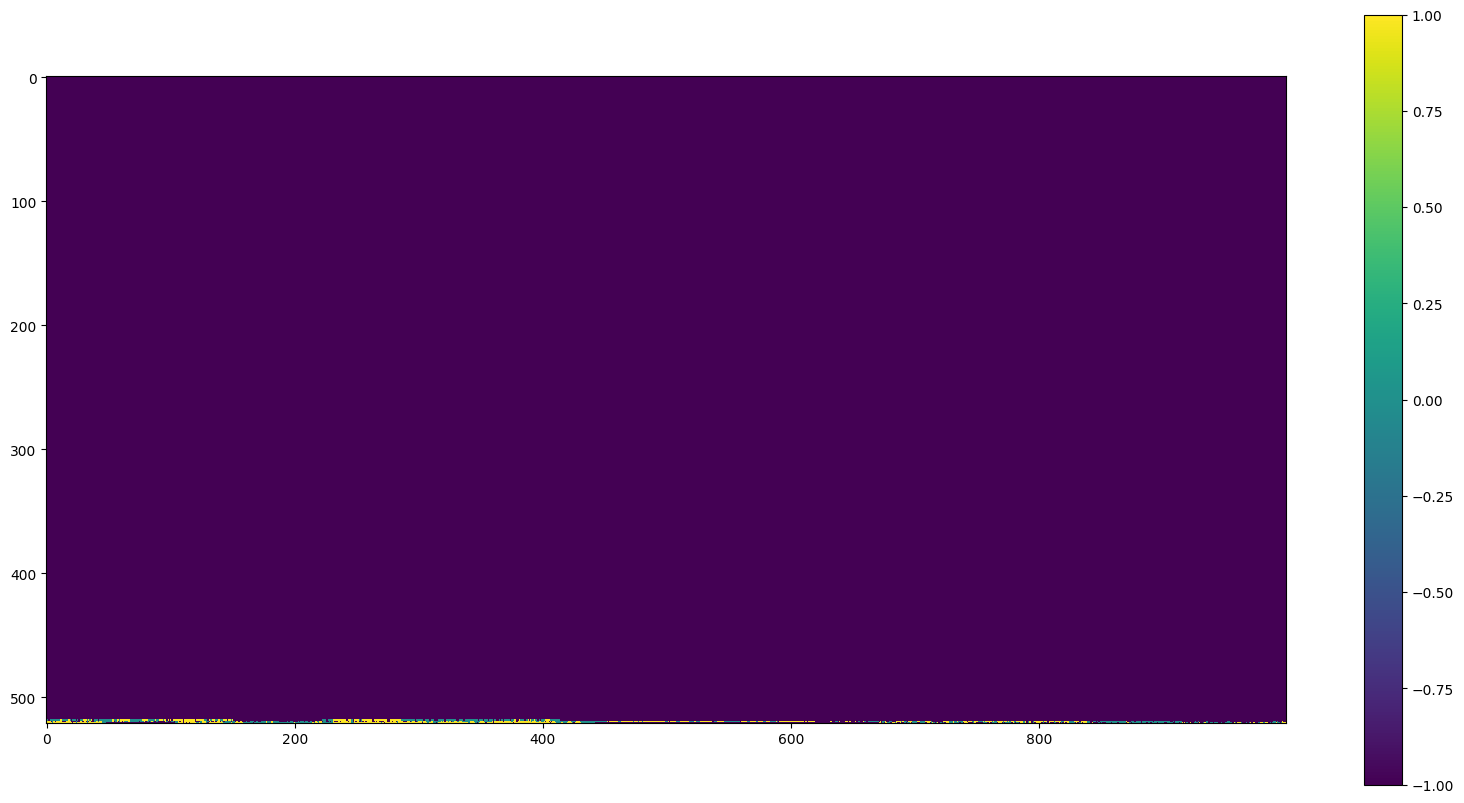

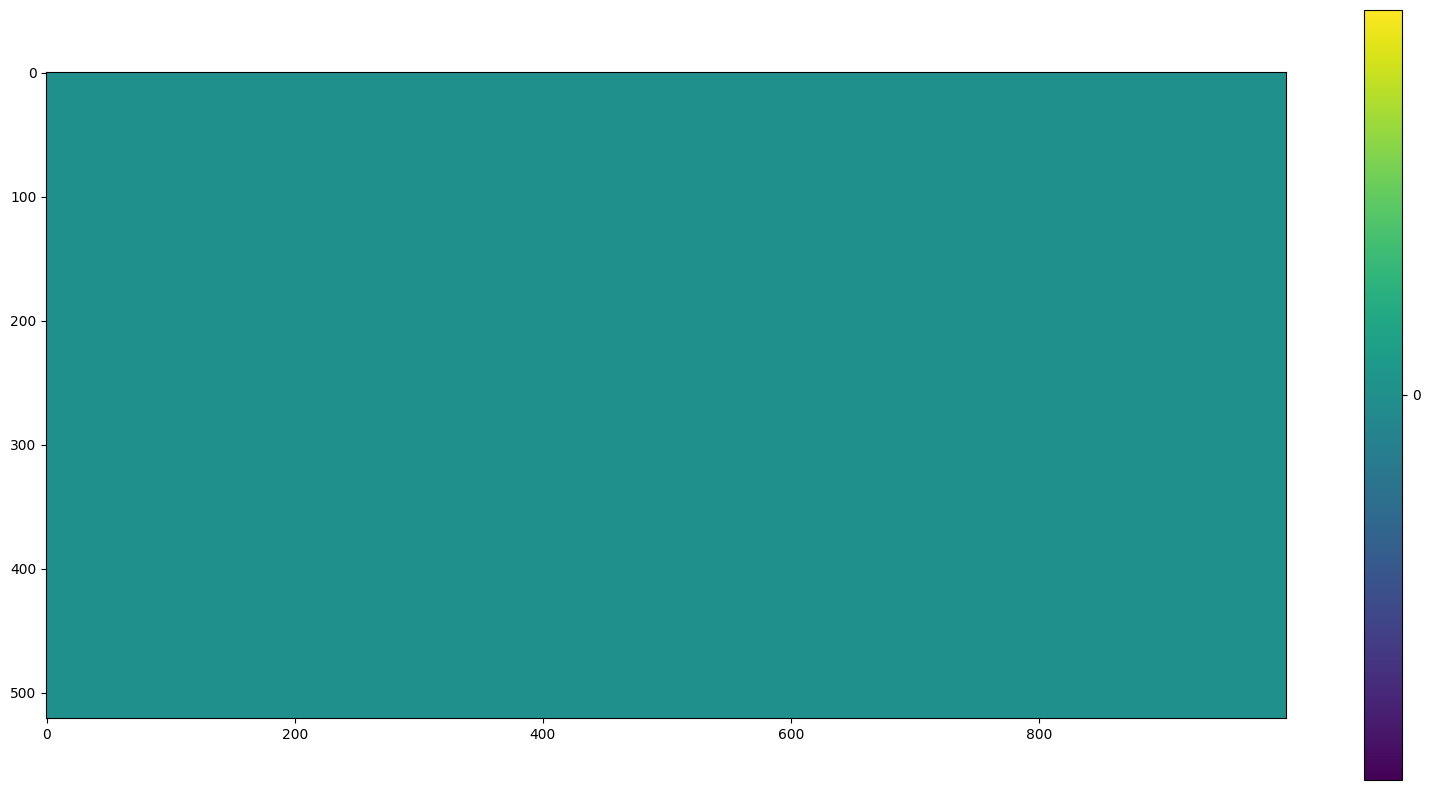

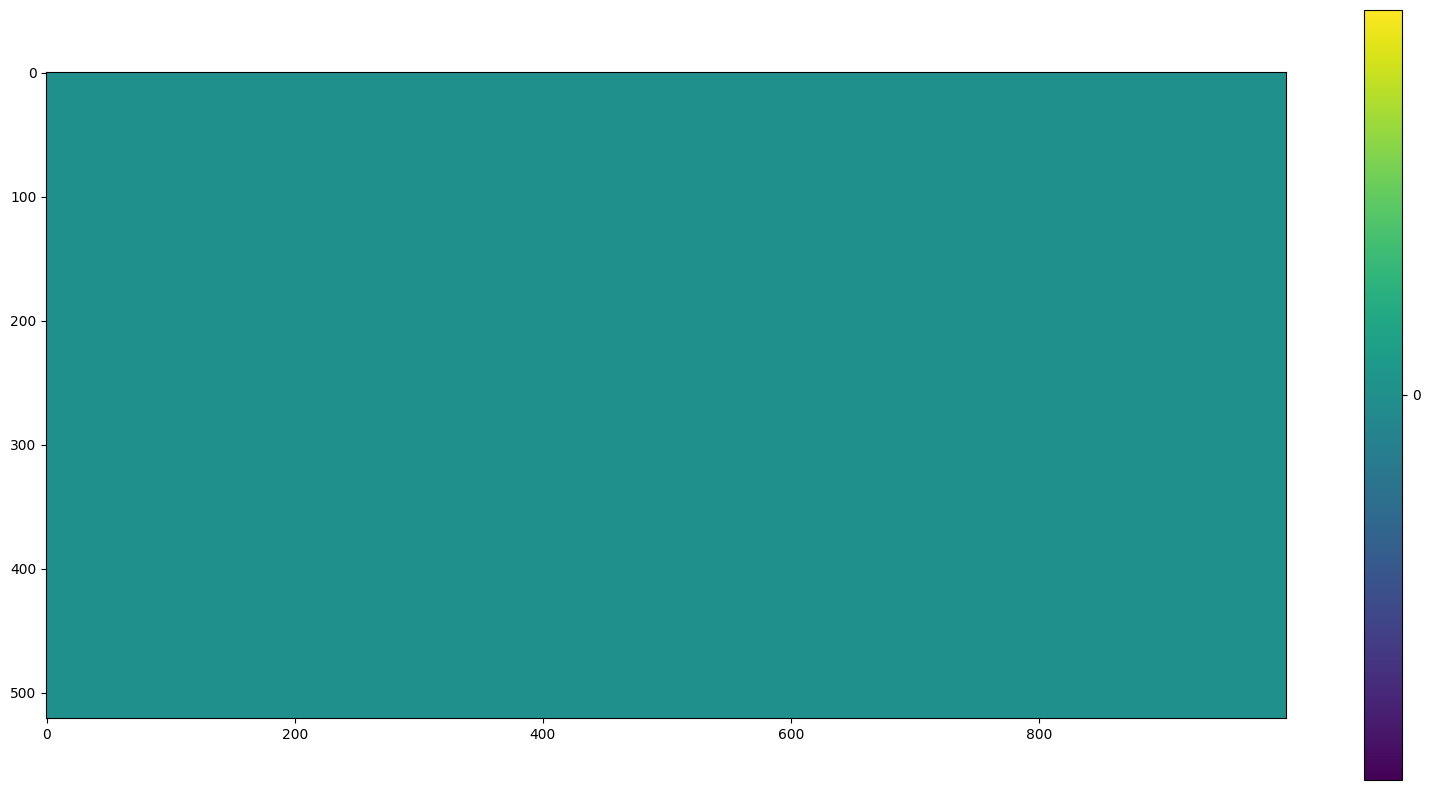

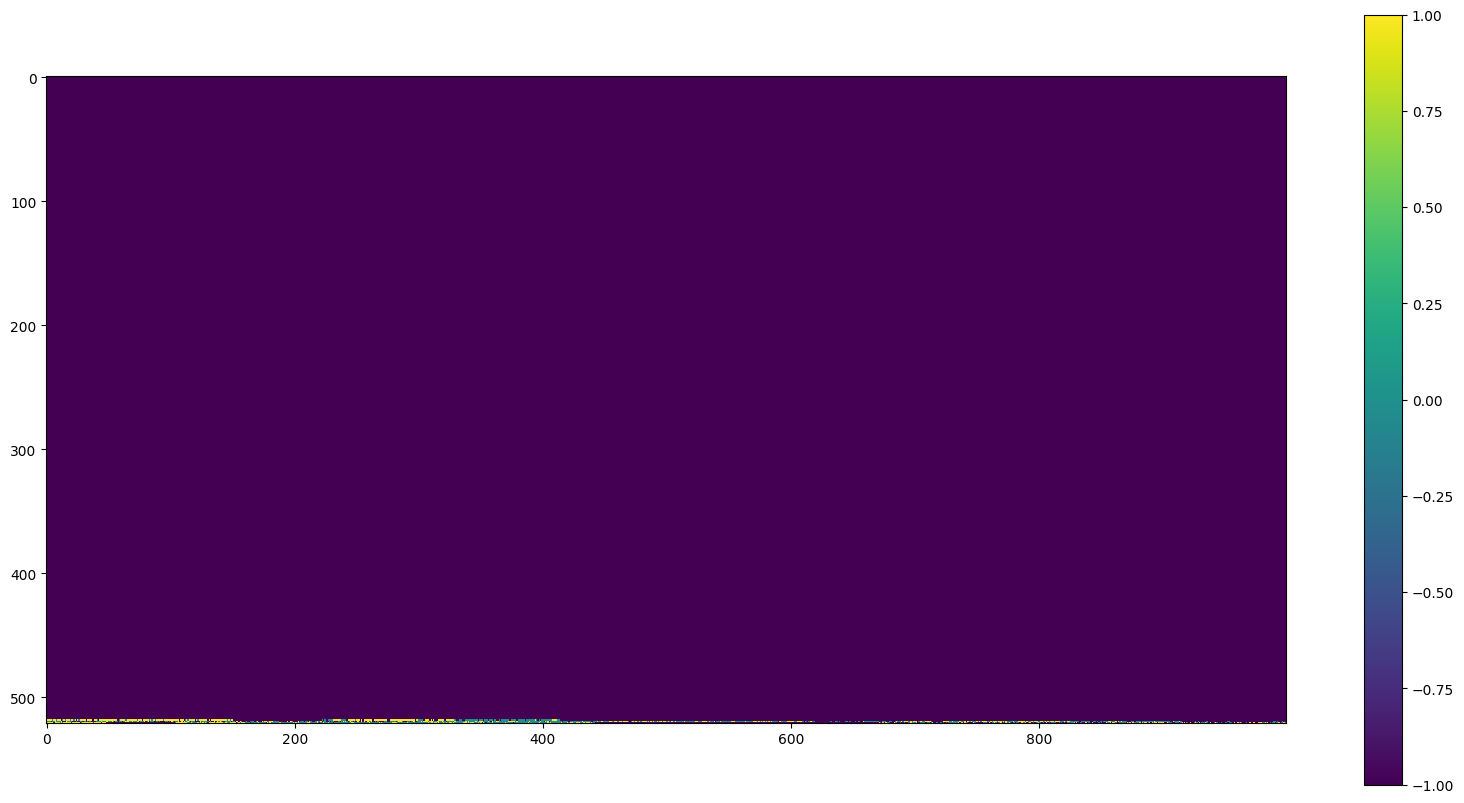

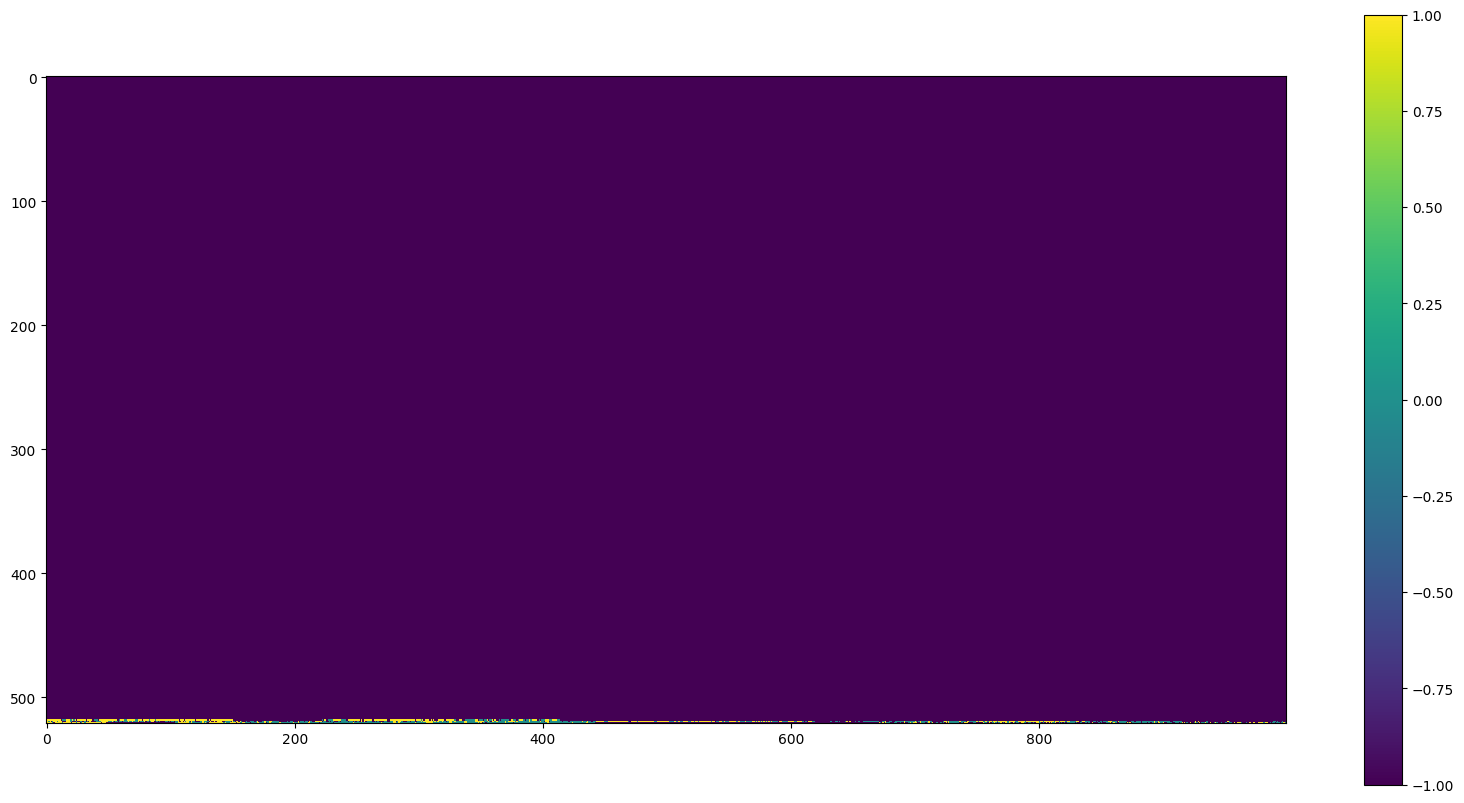

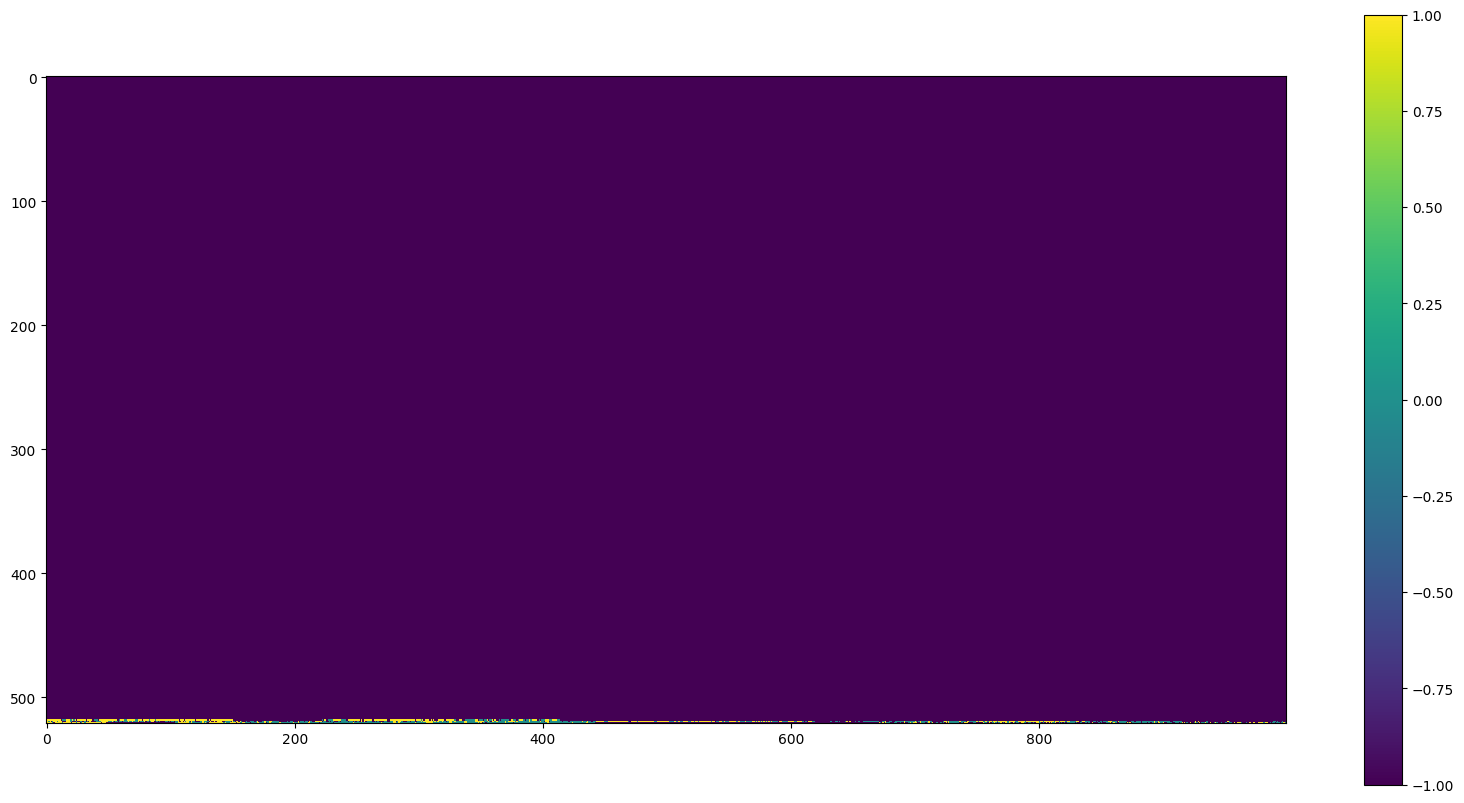

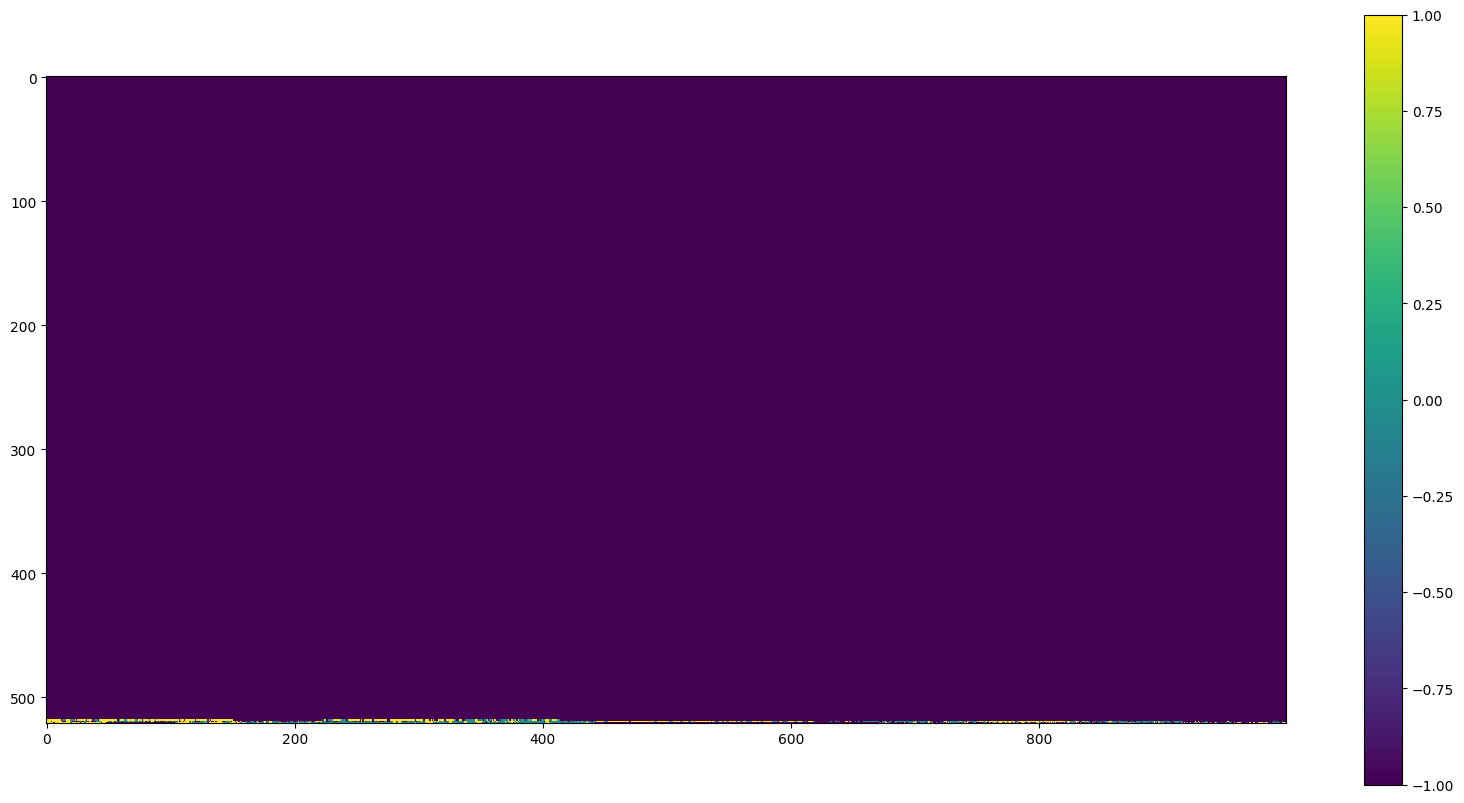

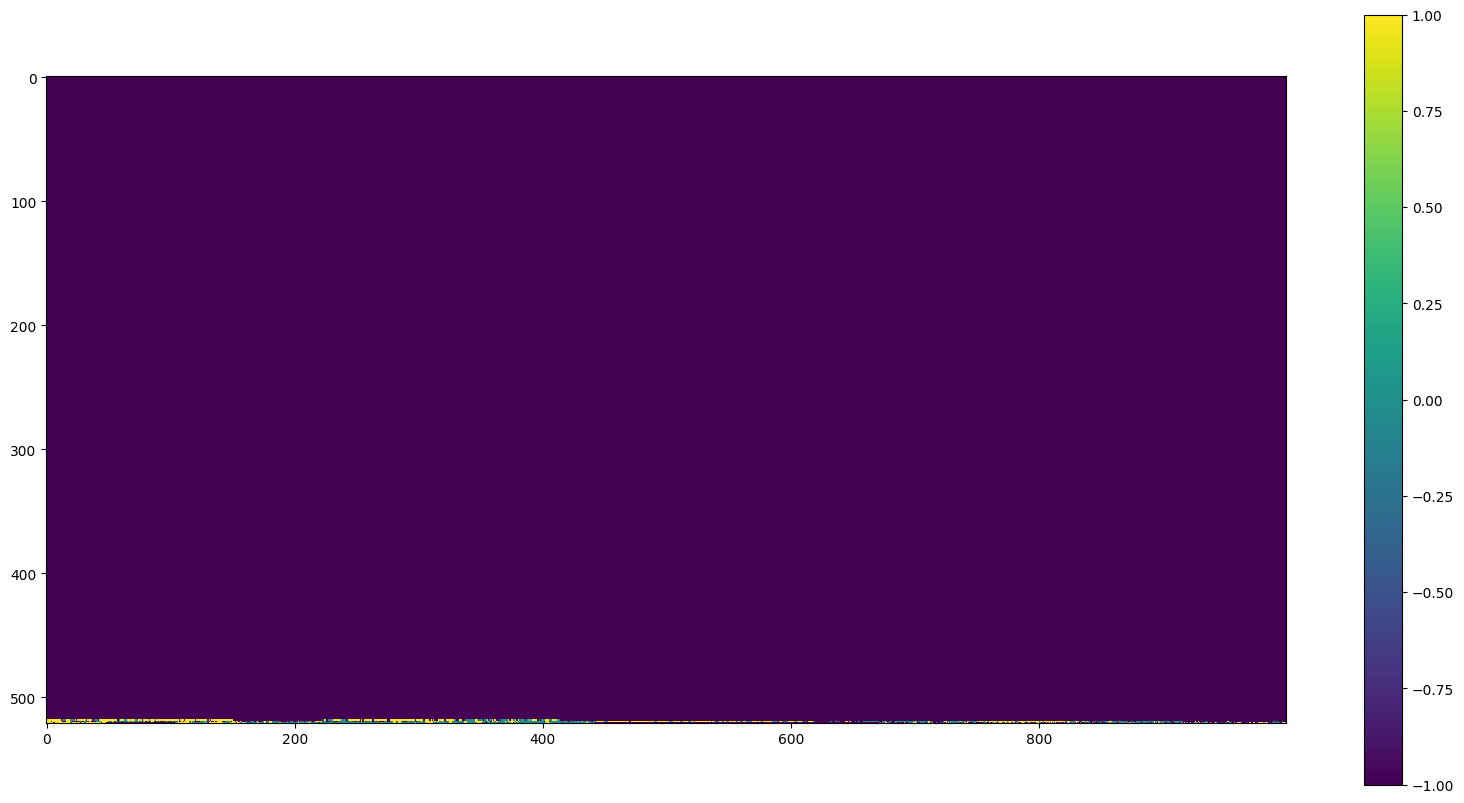

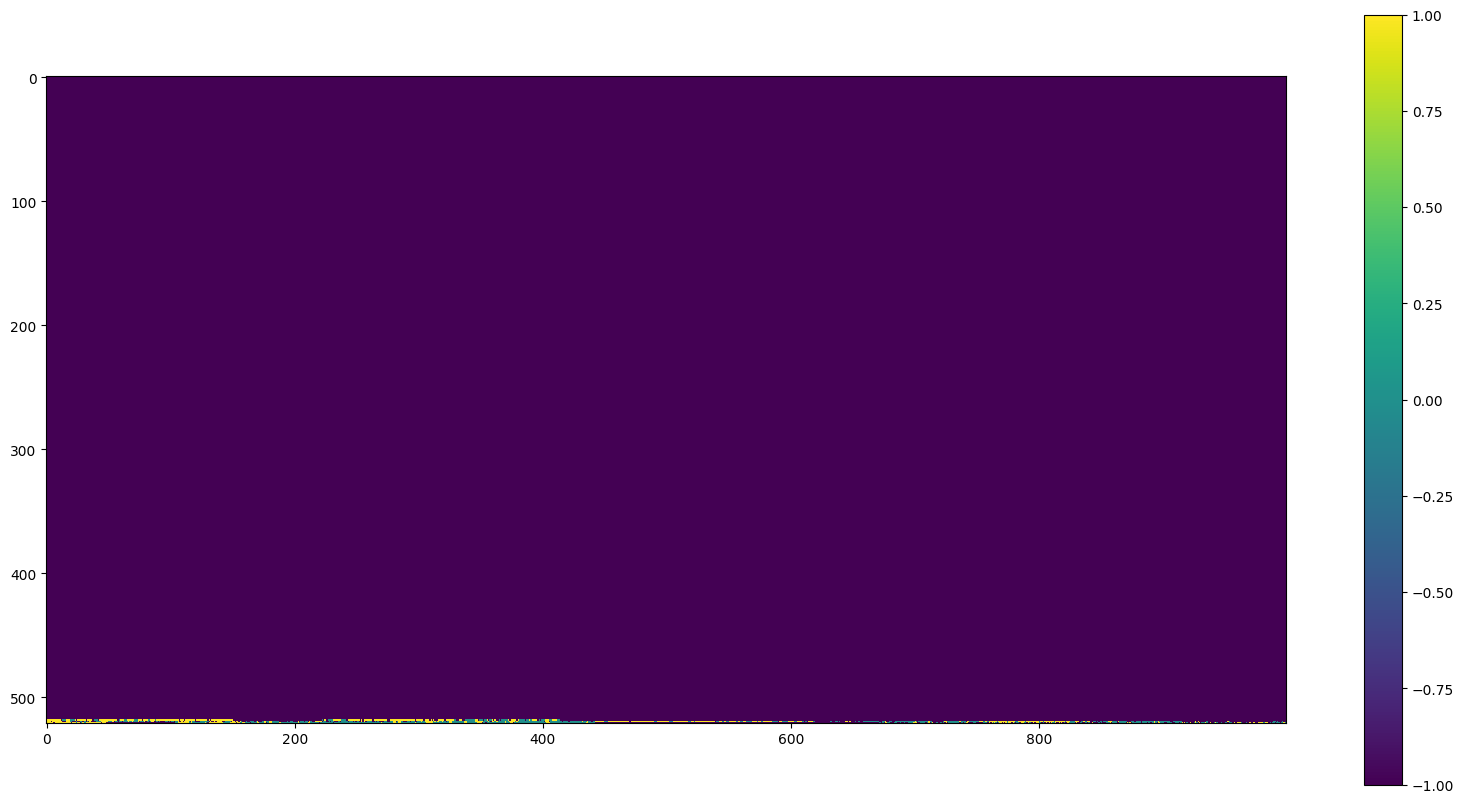

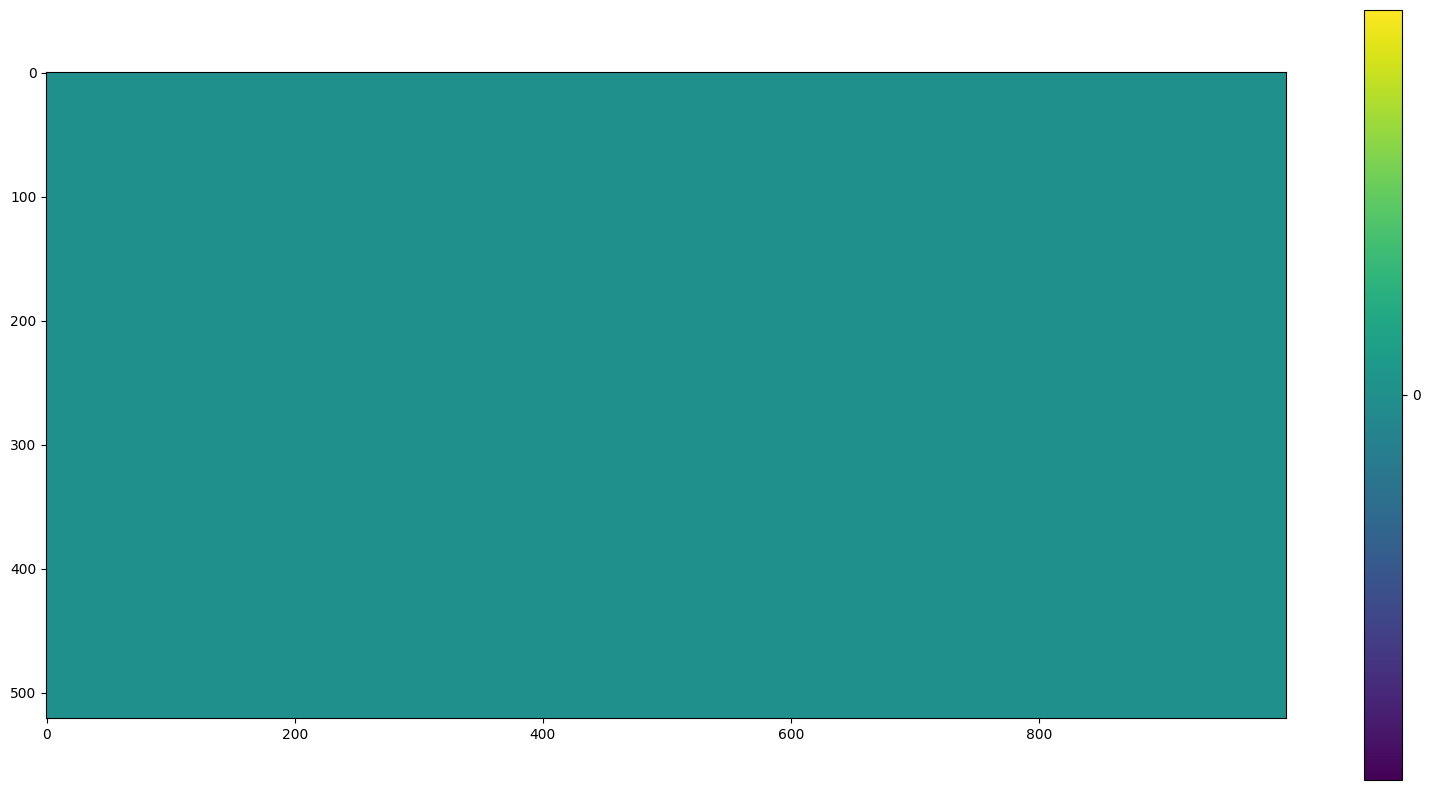

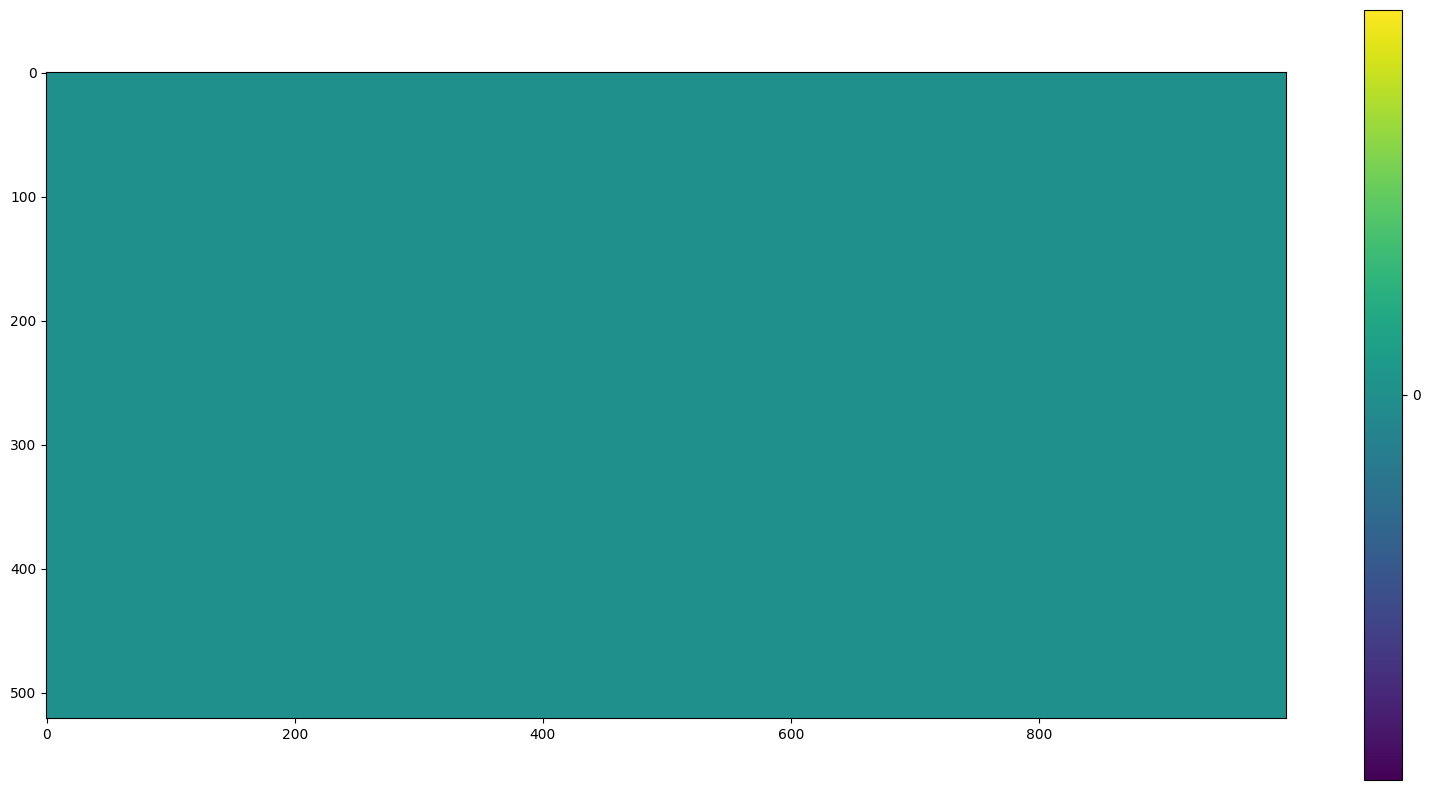

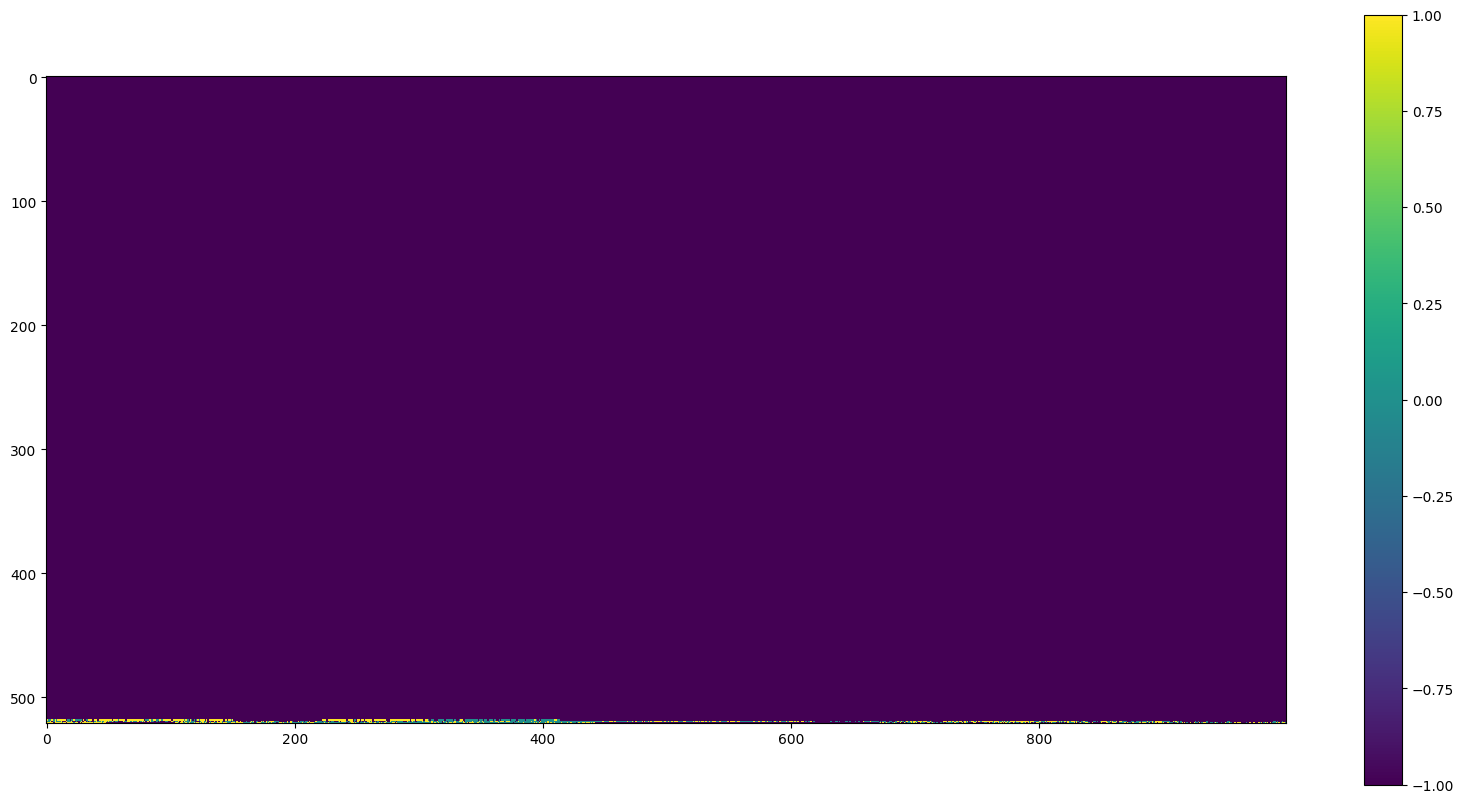

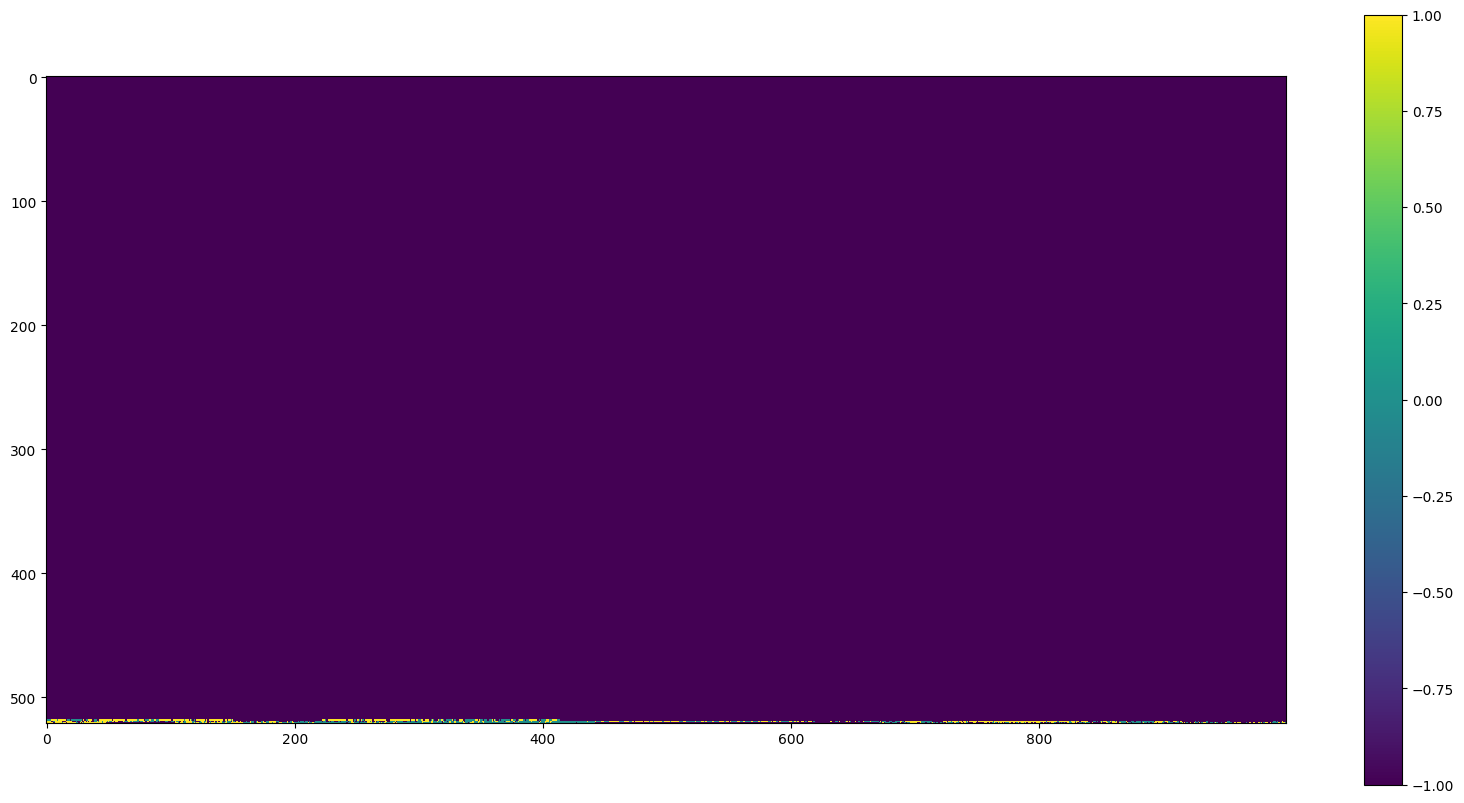

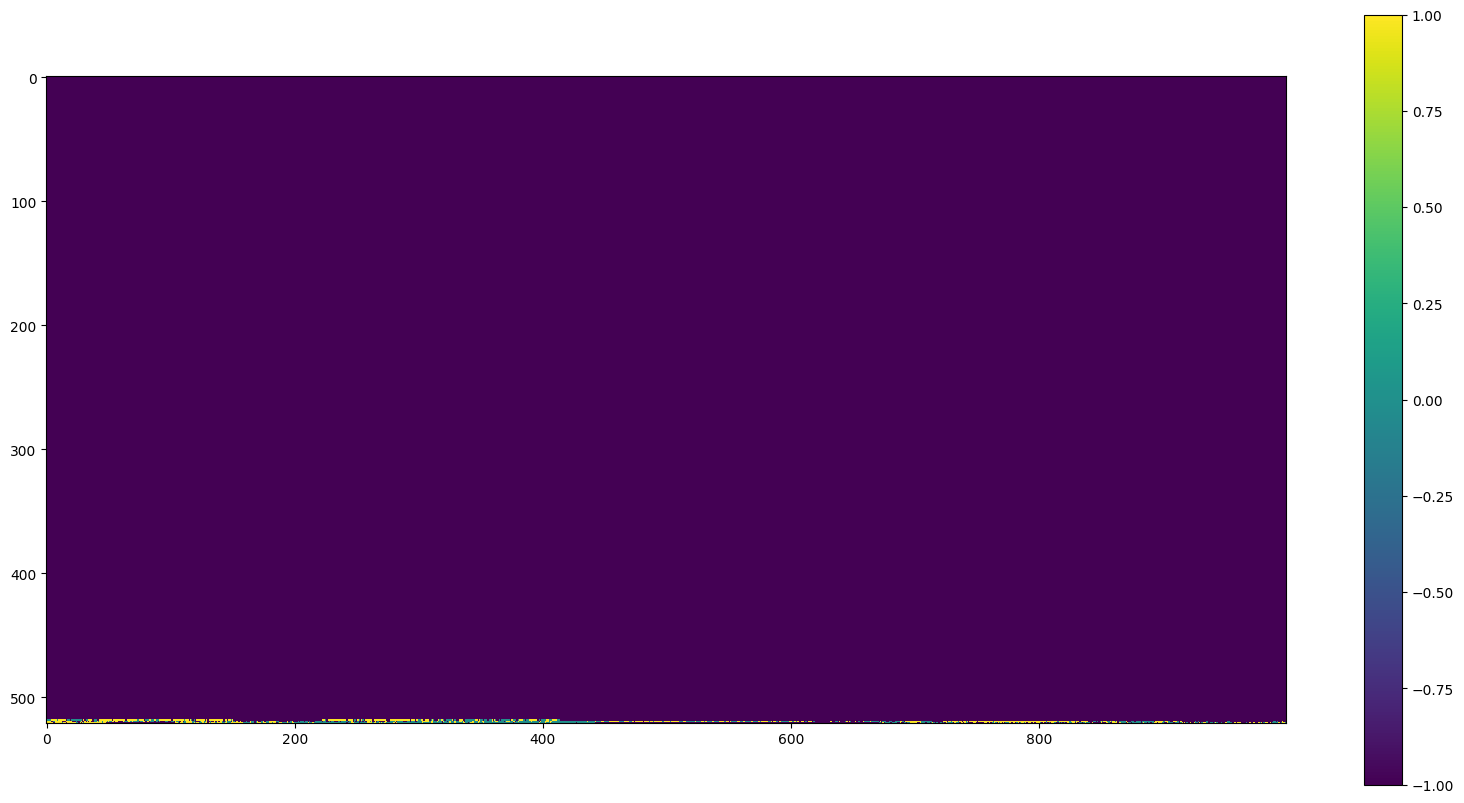

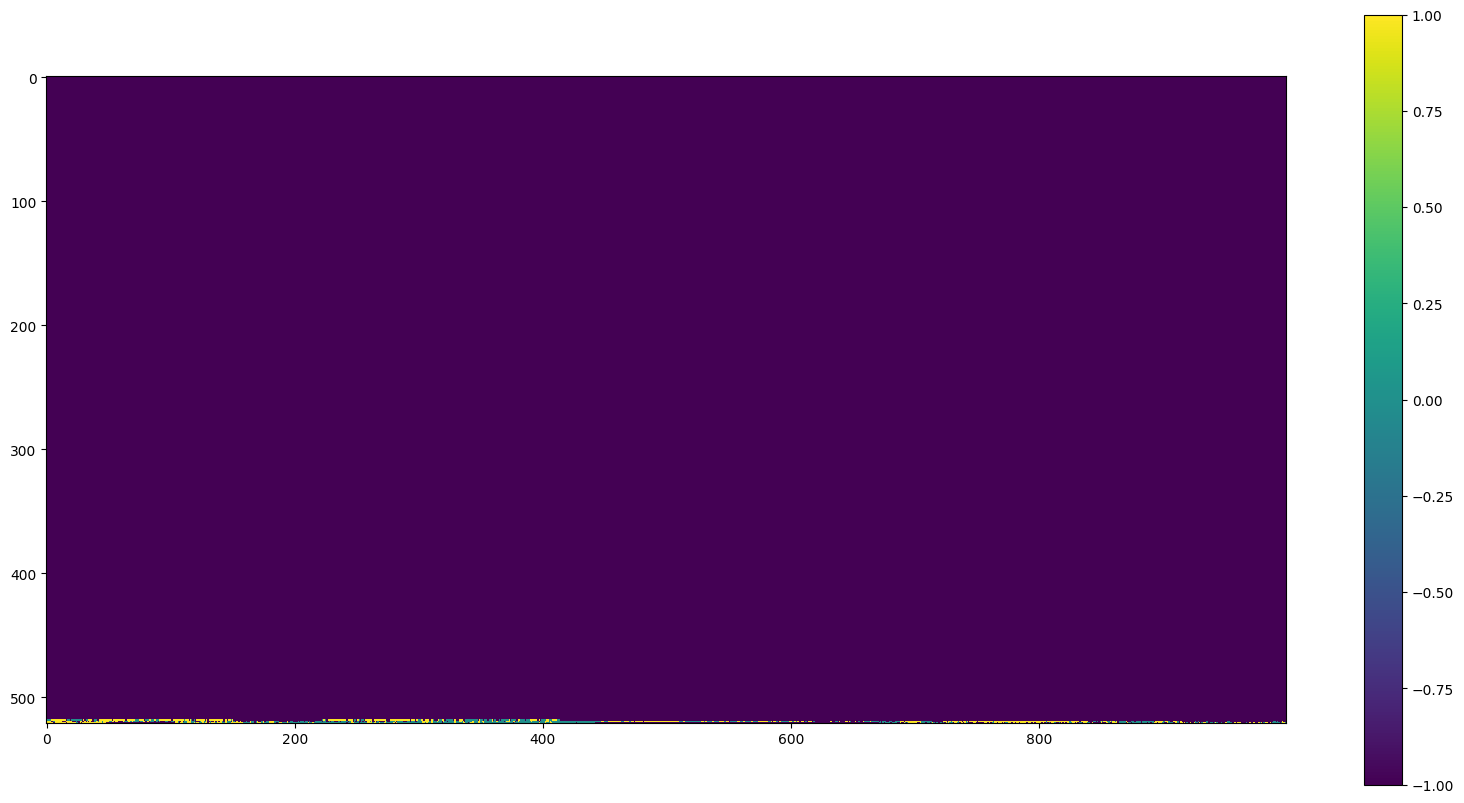

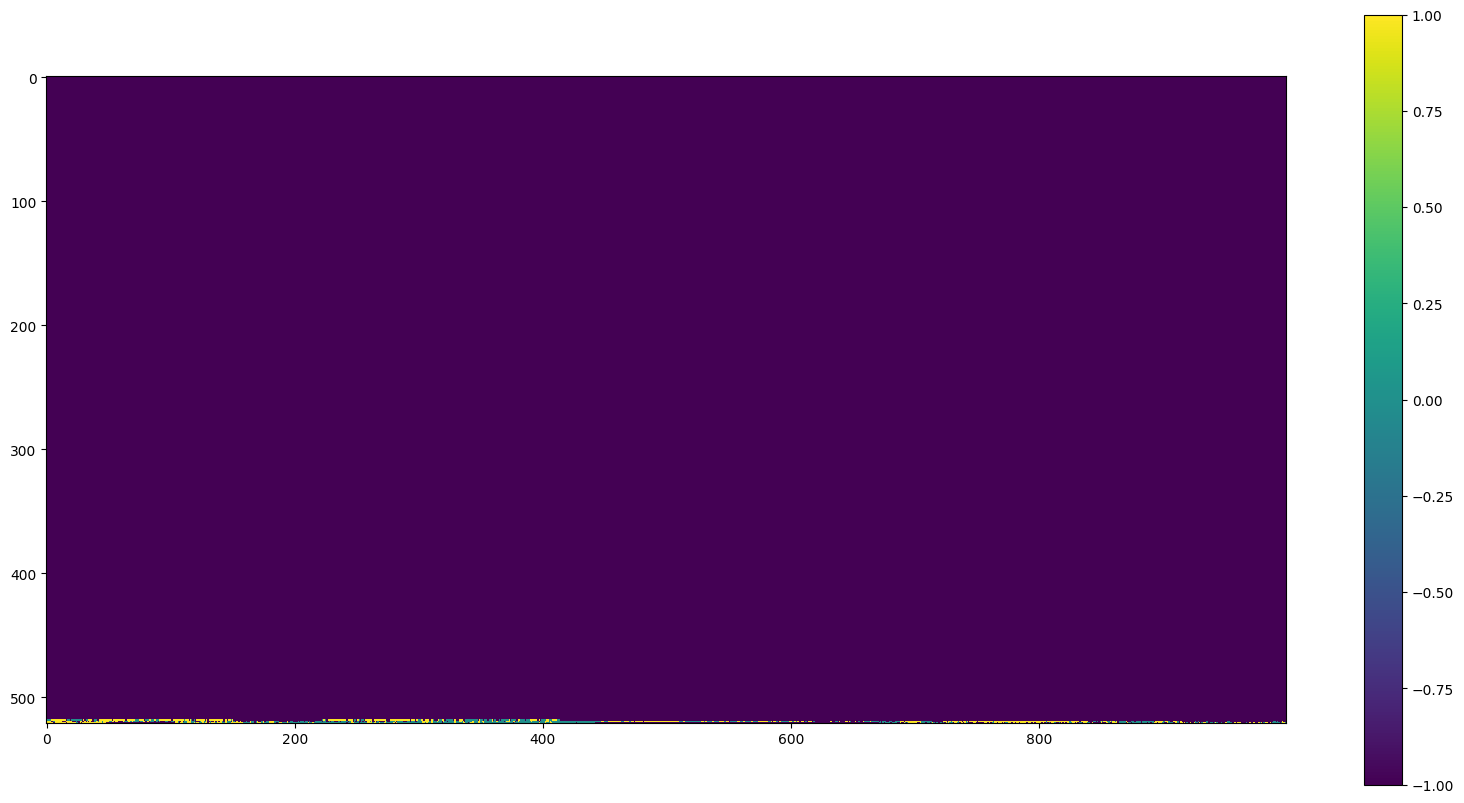

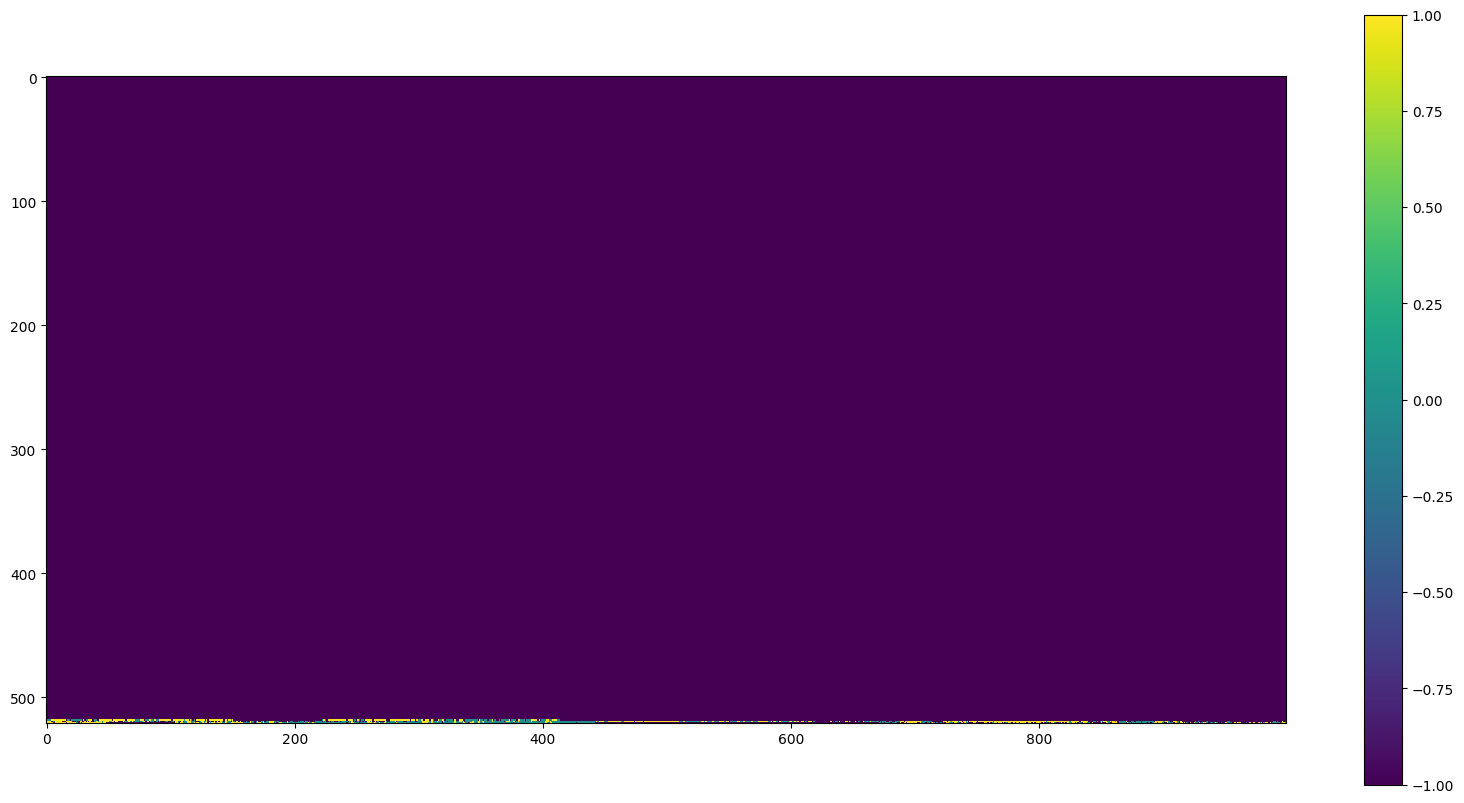

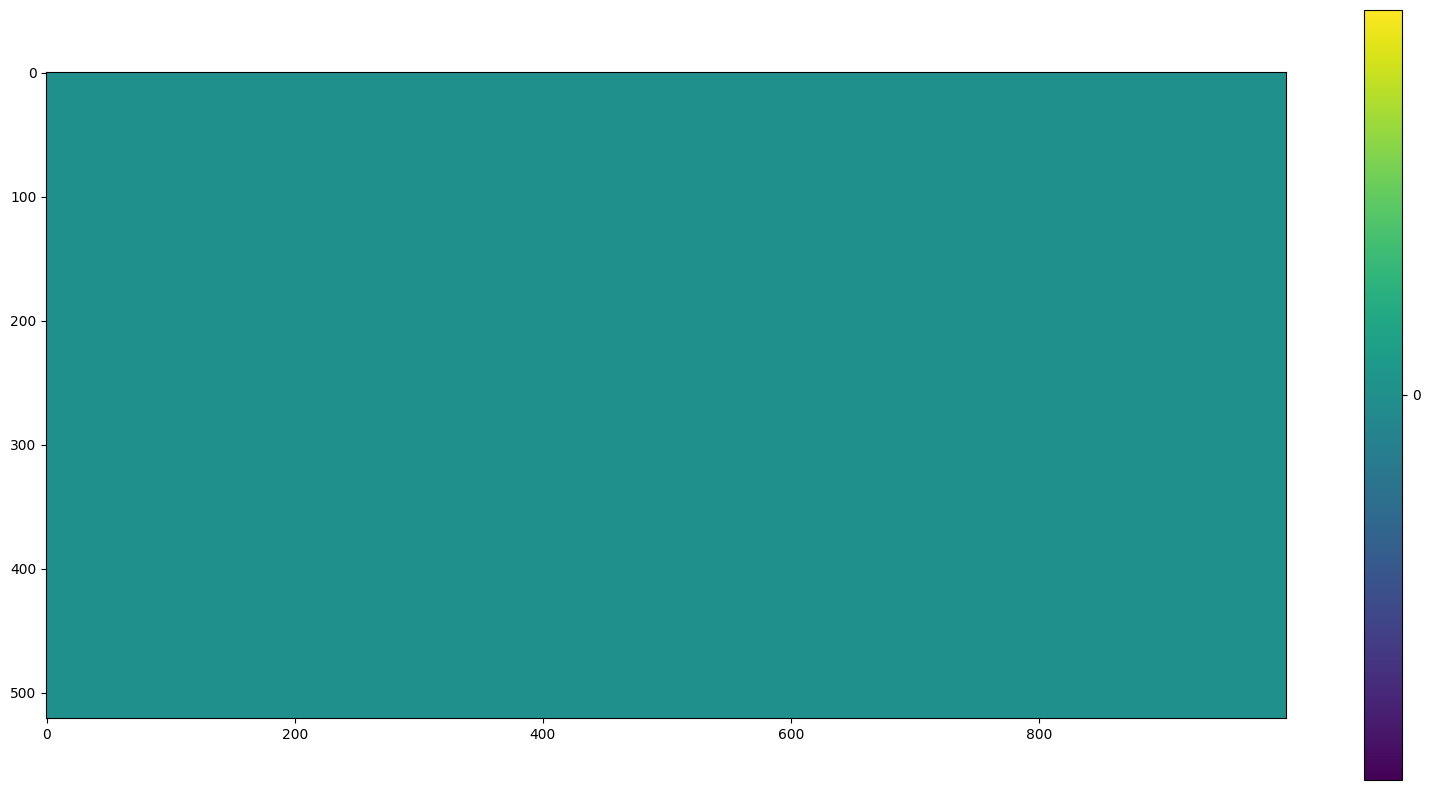

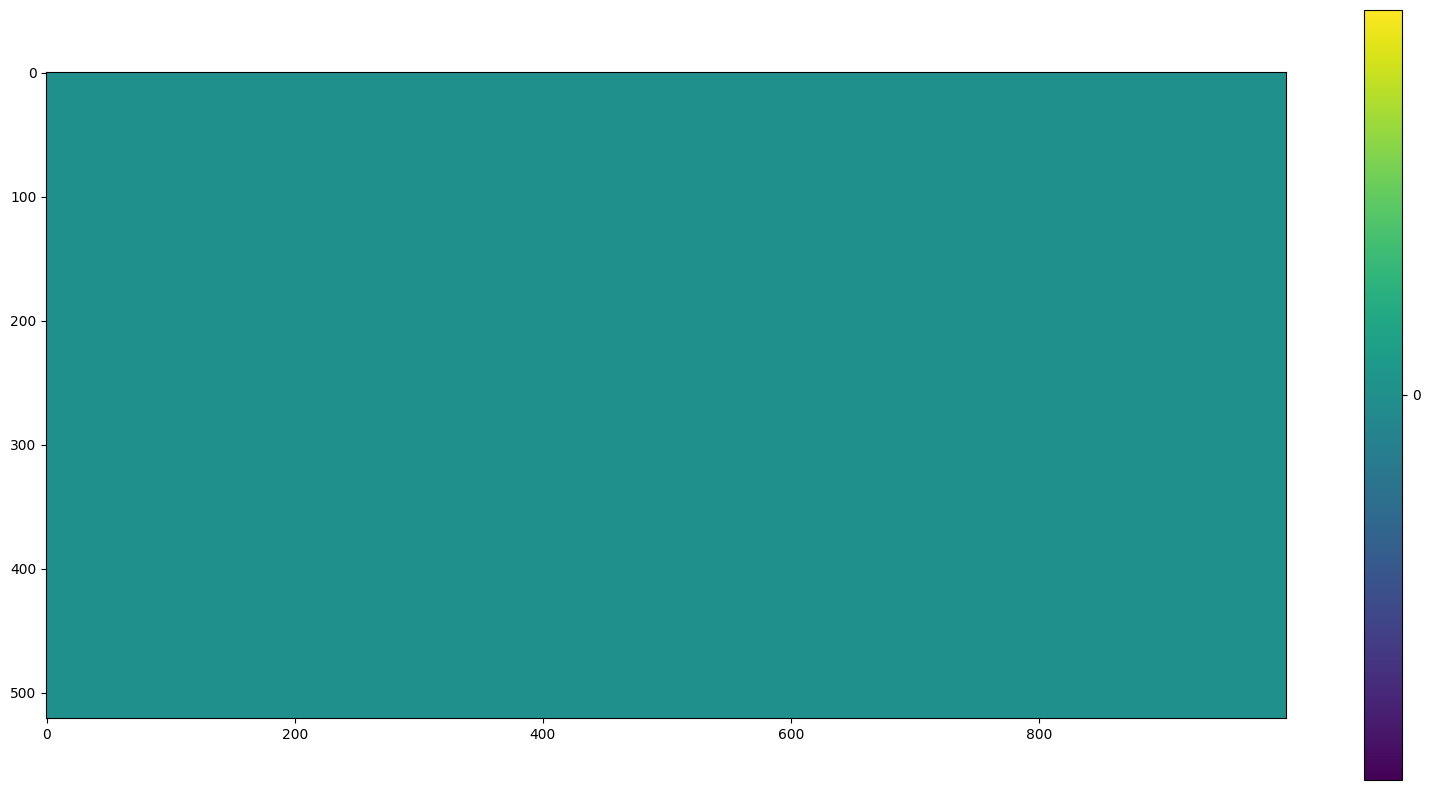

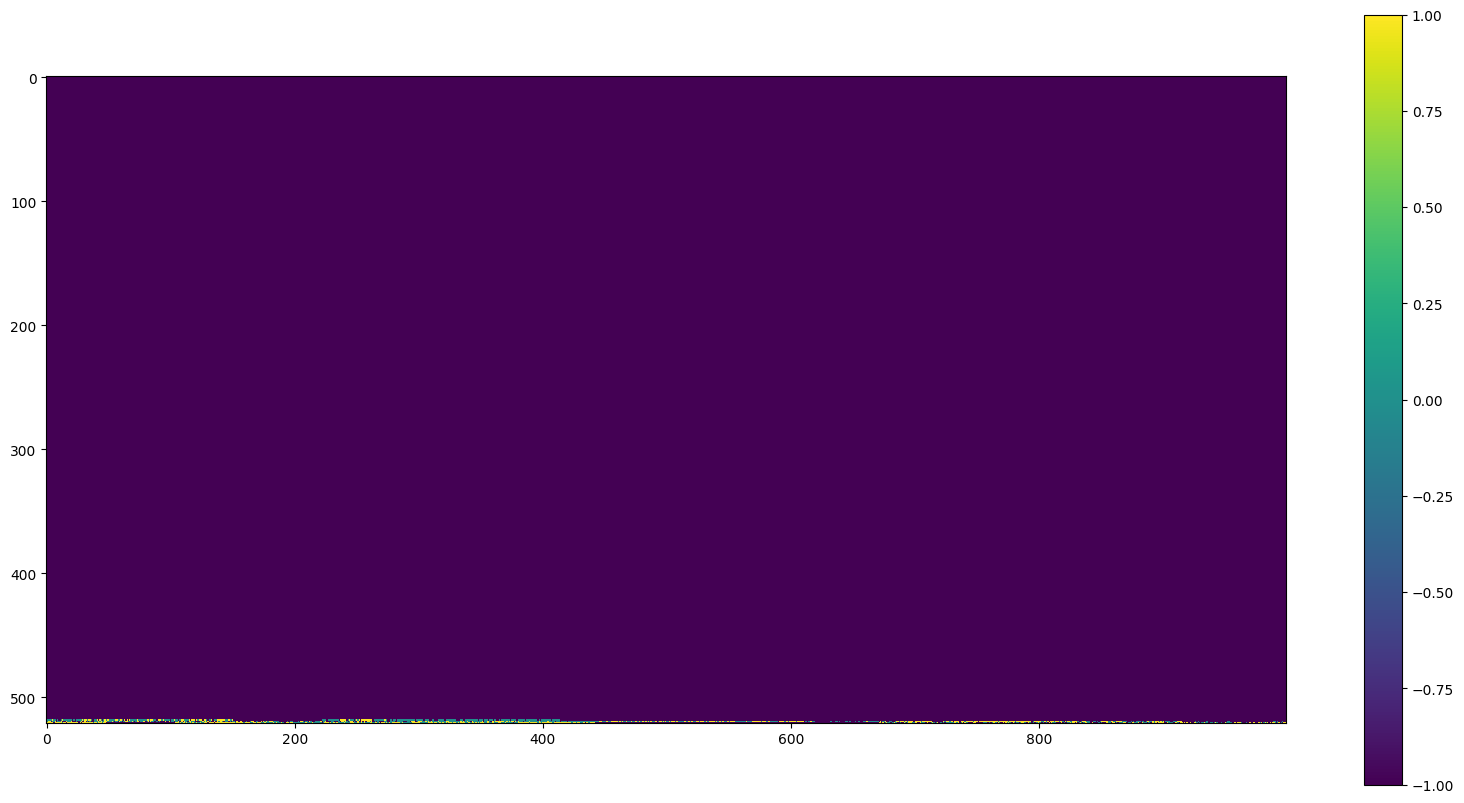

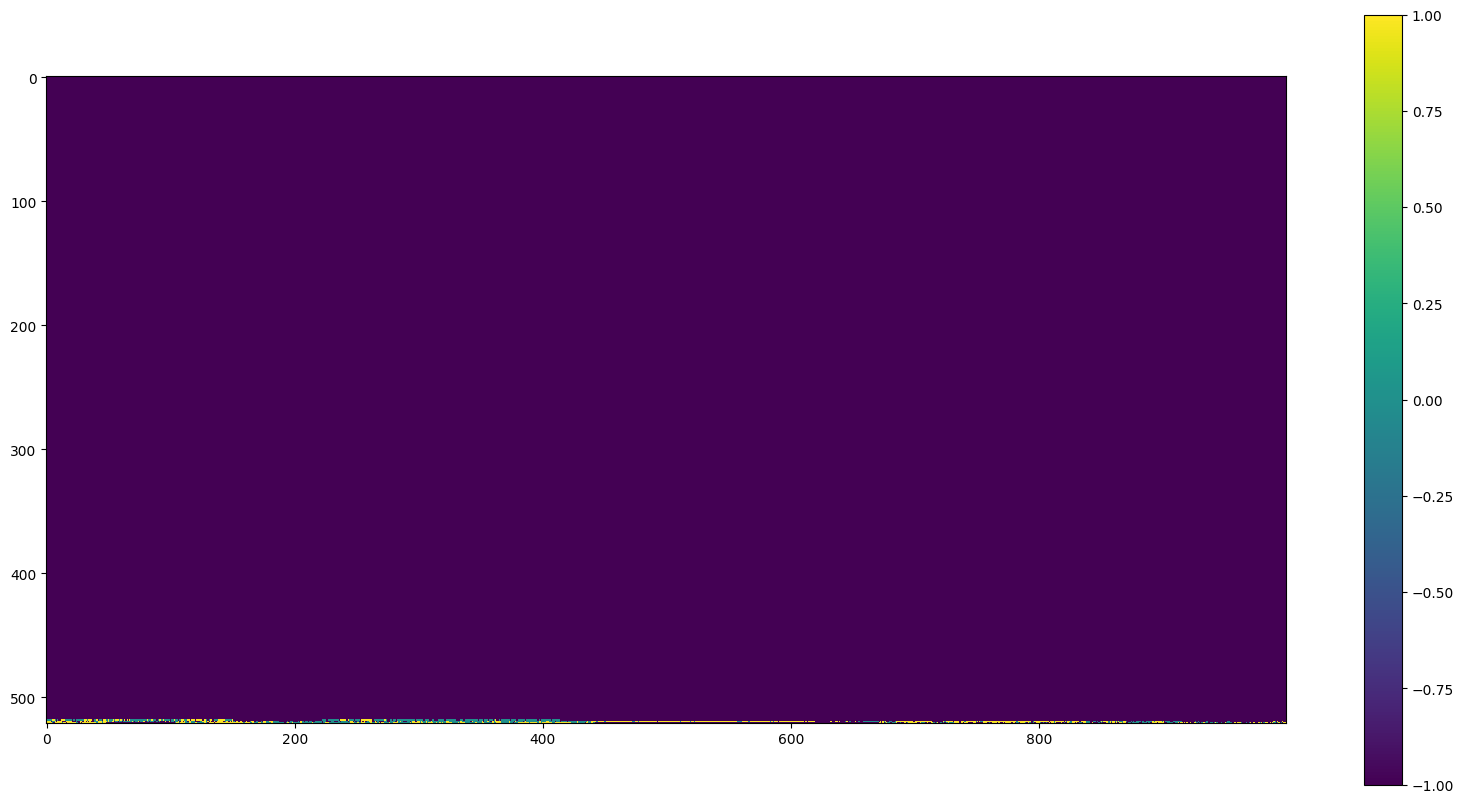

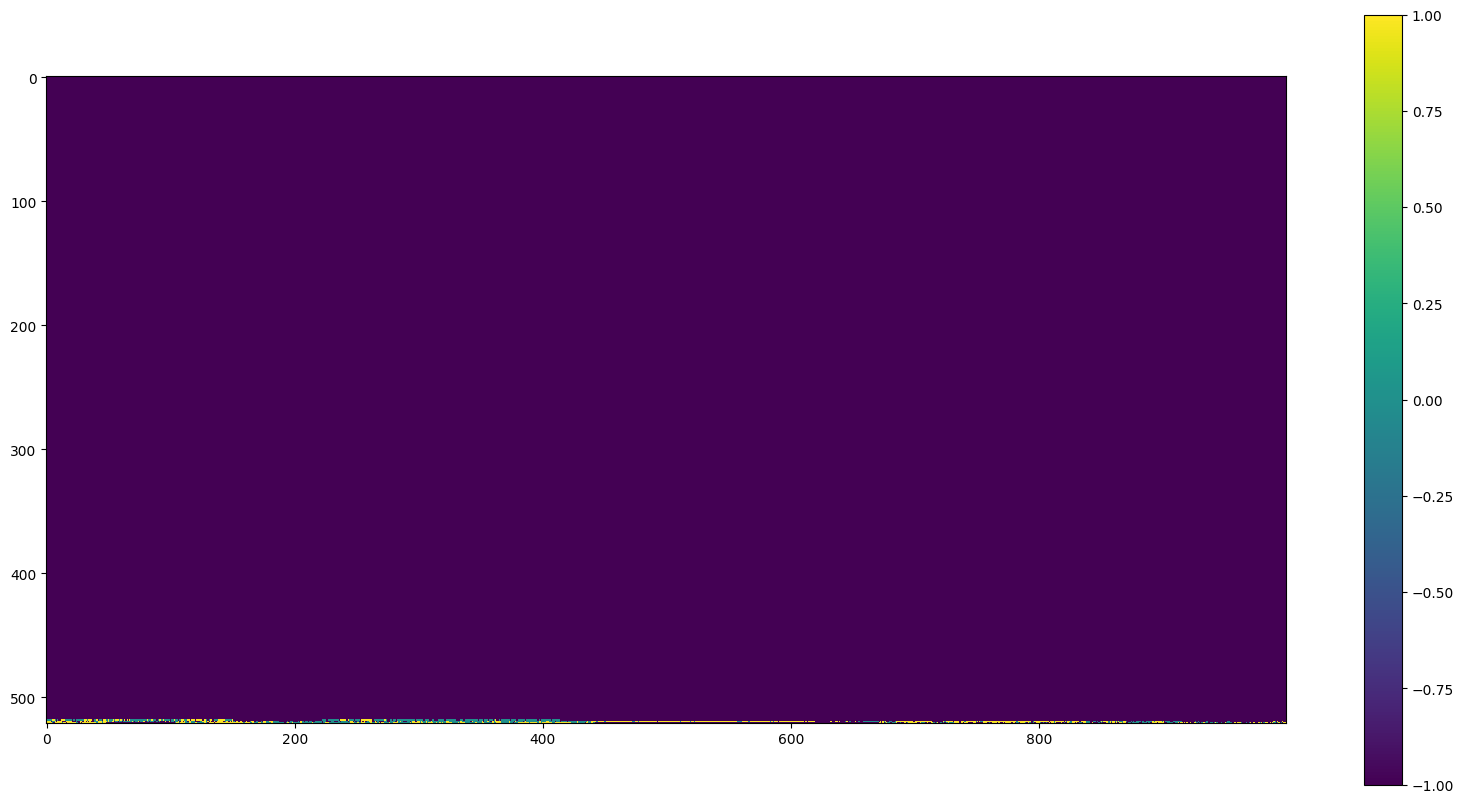

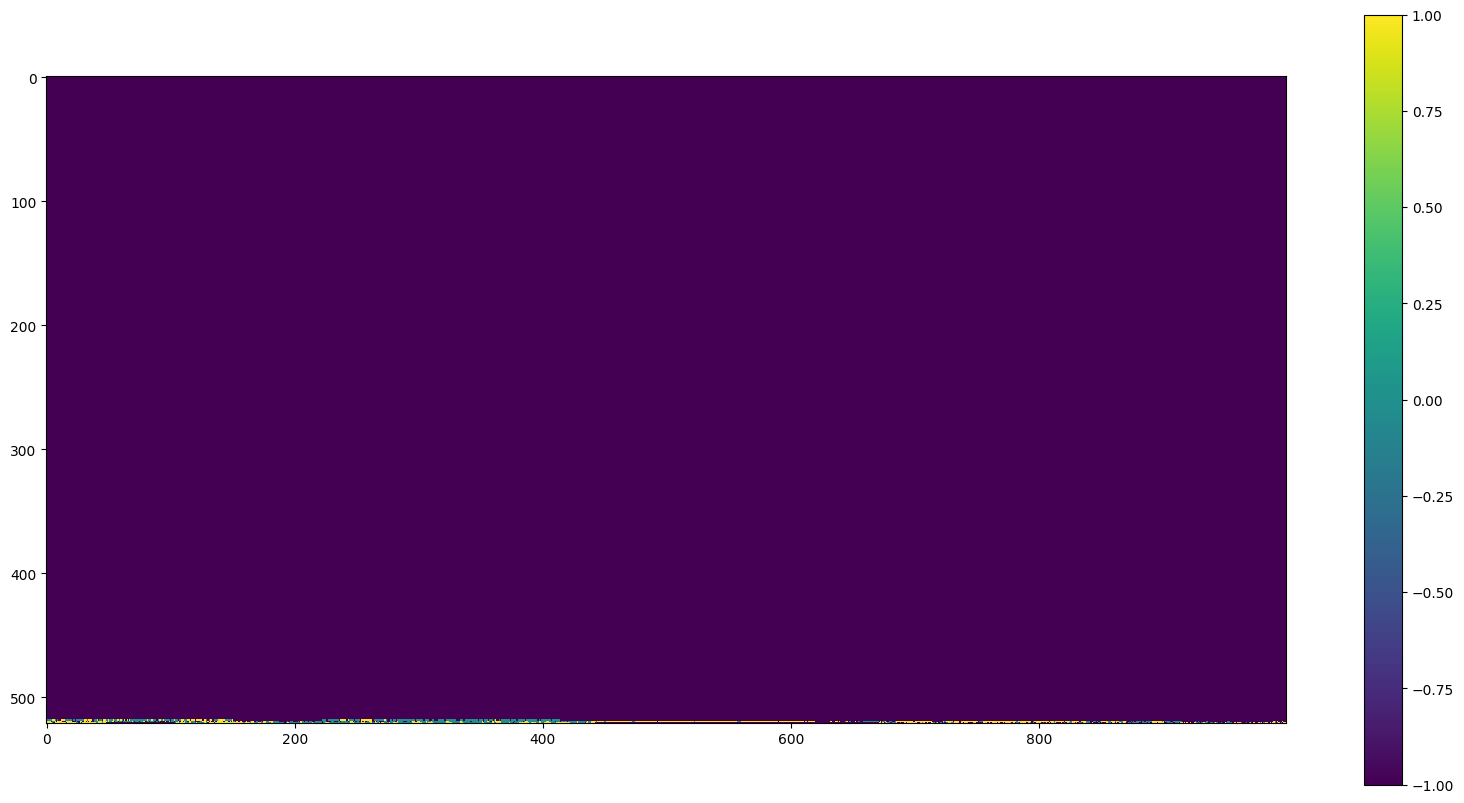

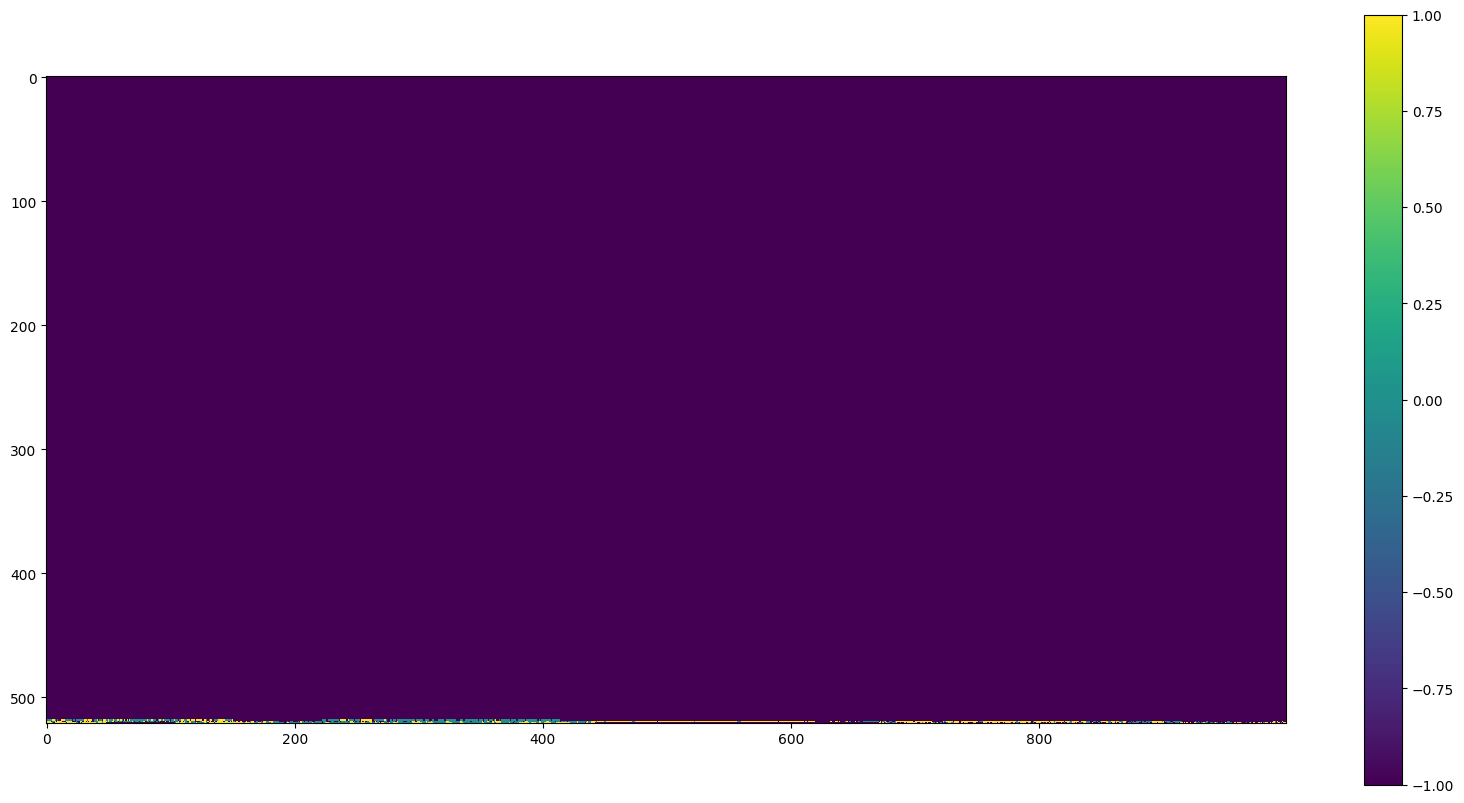

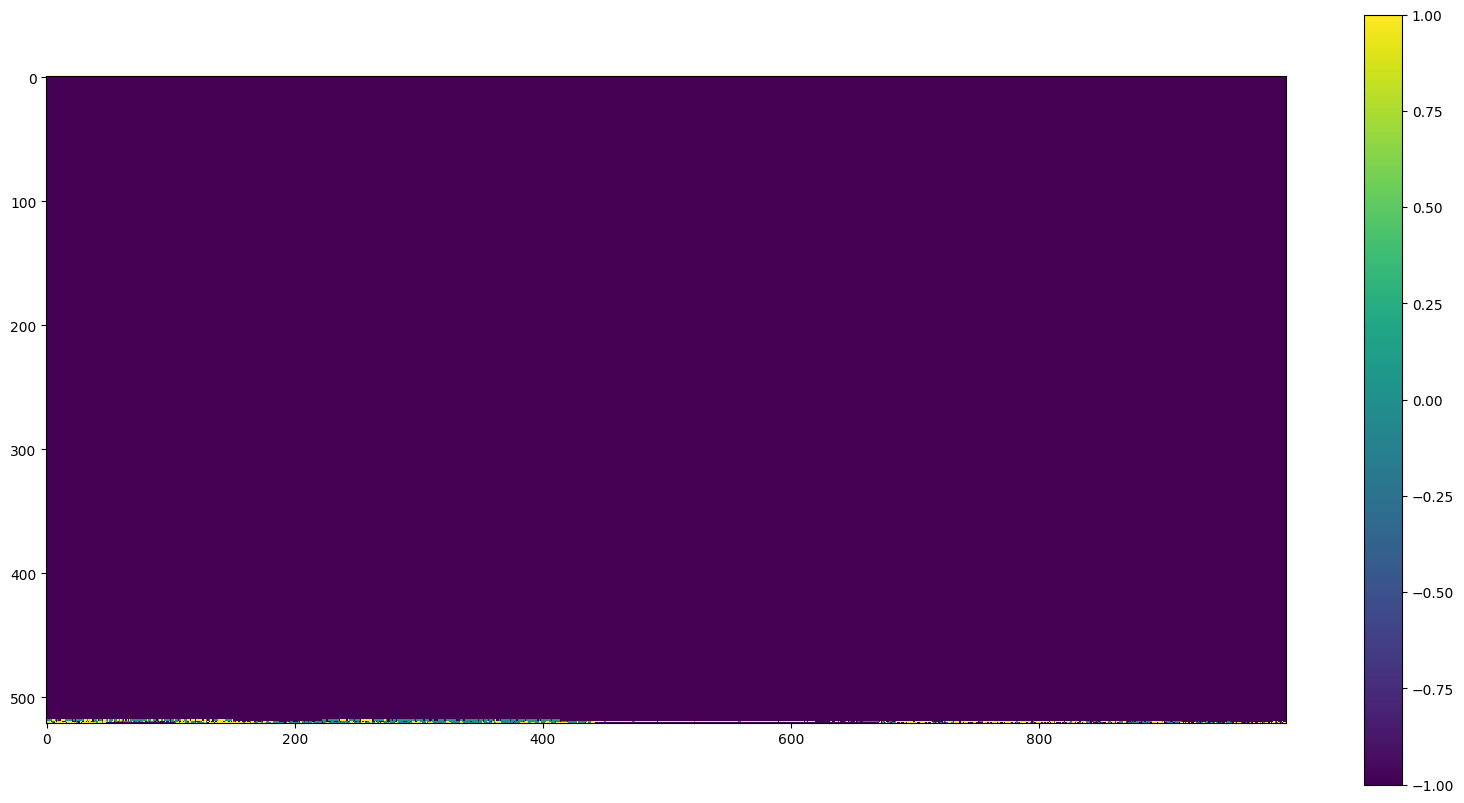

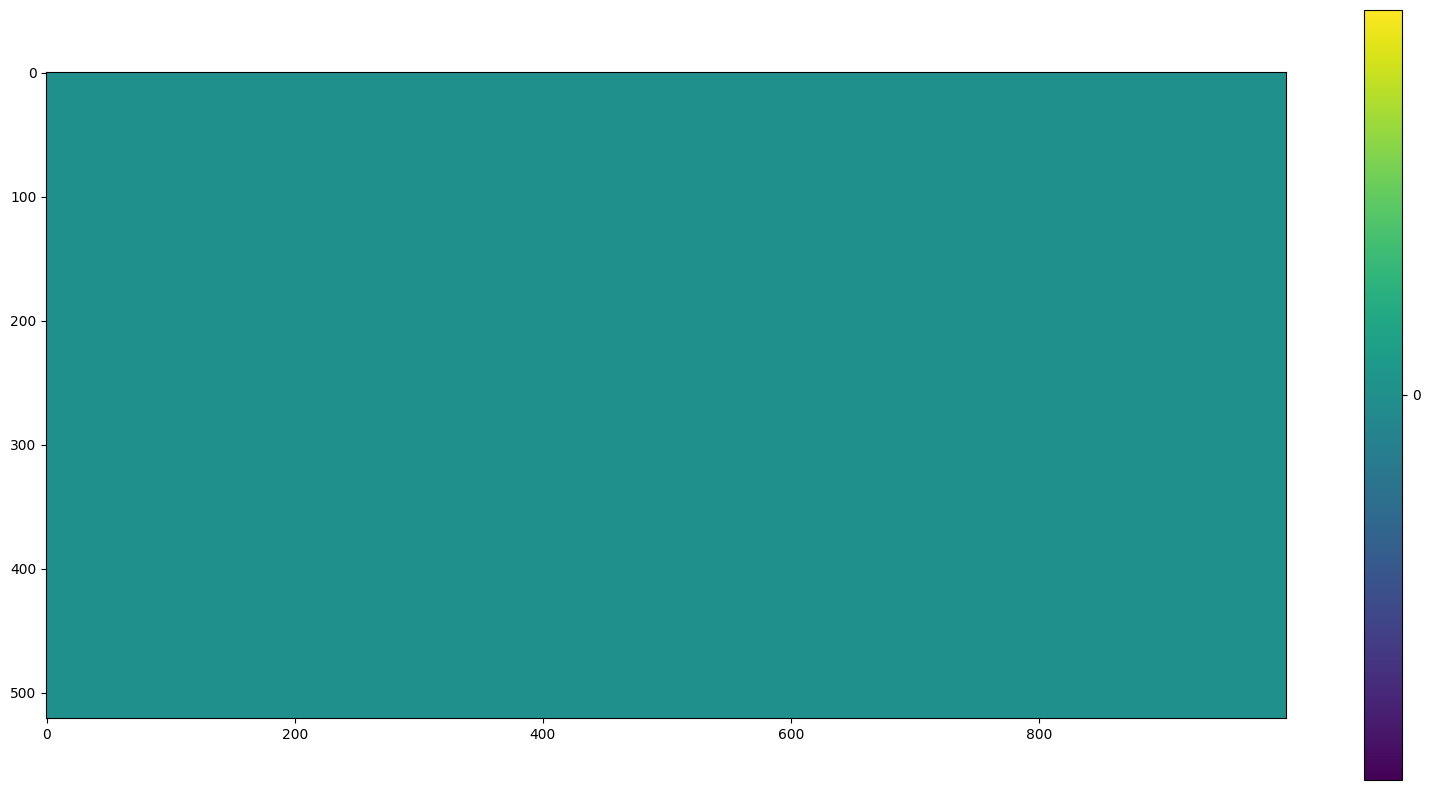

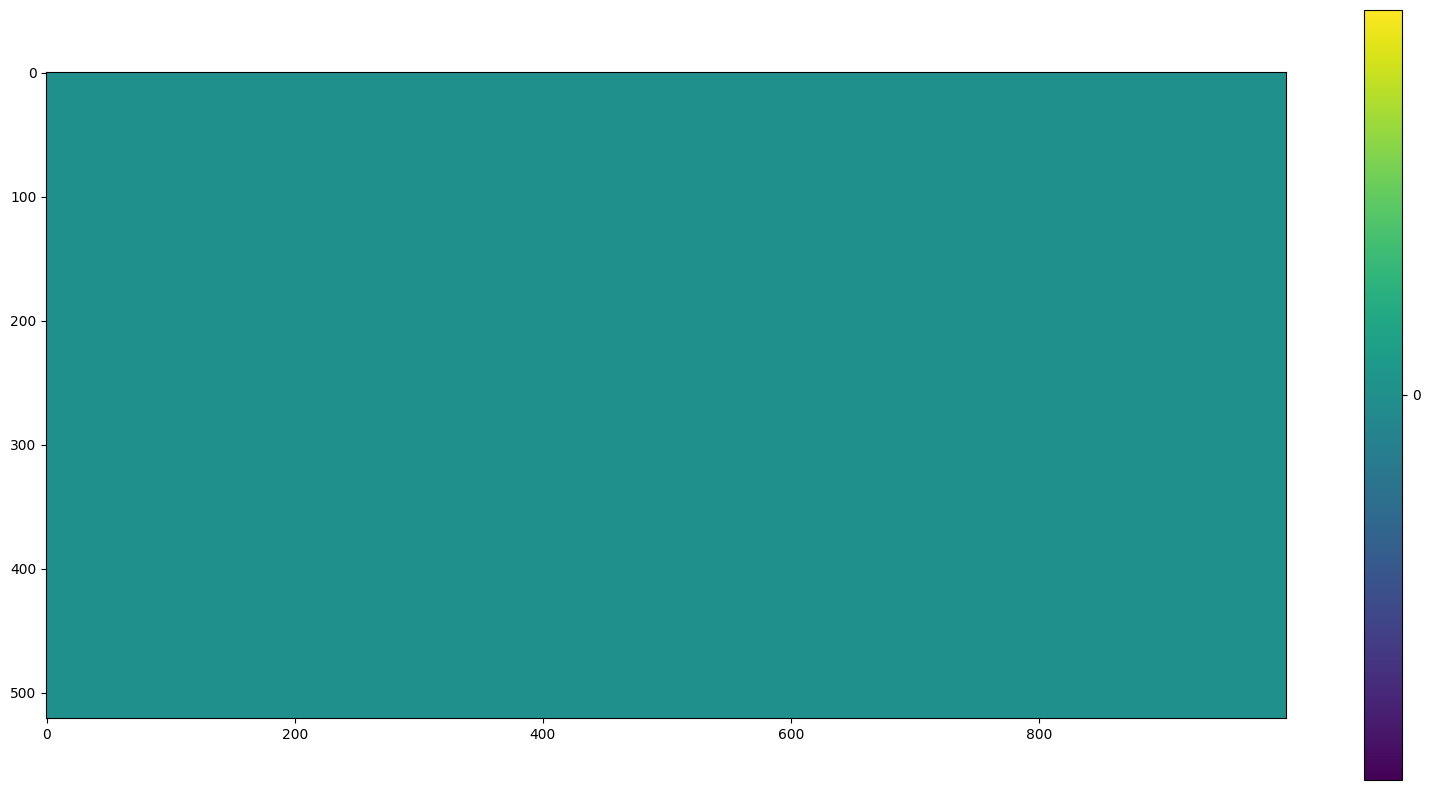

In [9]:
results_df= pd.DataFrame(columns=['year','precision', 'recall', 'f1', 
                                 'precision_base', 'recall_base', 'f1_base'])

y_pred_test = pd.DataFrame(columns=['year', 'month','adm_code','fews_ipc_crisis_pred','fews_ipc_crisis_true'])
#train test split
for year in range(2021,2025):
    # Xtrain, ytrain, Xtest, ytest = train_test_split(X, y, test_ratio = TEST_RATIO)
    (Xtrain, ytrain, Xtrain_loc, Xtrain_group,
    Xtest, ytest, Xtest_loc, Xtest_group) = train_test_split_by_year(
        X, y, X_loc, X_group, df['years'].values, test_year=year)
    ytrain = ytrain.astype(int)
    ytest  = ytest.astype(int)        # if evaluating later
    #define georf
    #max_model_depth: max depth of the hierarchical partitioning in GeoRF
    #max_depth: max depth of each tree in random forest (10 used in demo to reduce execution time)
    #n_jobs: number of cores to use to run the model in parallel
    georf = GeoRF(min_model_depth = MIN_DEPTH,	max_model_depth = MAX_DEPTH, n_jobs = N_JOBS)#, max_depth=10
    #definition with all parameters
    #dir: defaulted to "result" in code (auto-generated), no need to change
    # georf = GeoRF(min_model_depth = MIN_DEPTH,	max_model_depth = MAX_DEPTH, dir = "",
    # 							n_trees_unit = 100, num_class = NUM_CLASS, max_depth=None, random_state=5, n_jobs = N_JOBS,
    # 							mode=MODE, name = 'RF', type = 'static', sample_weights_by_class = None)
    #training
    georf.fit(Xtrain, ytrain, Xtrain_group, val_ratio = VAL_RATIO)
    #preidct
    ypred = georf.predict(Xtest, Xtest_group)
    #evaluatipn
    (pre, rec, f1,
    pre_base, rec_base, f1_base) = georf.evaluate(Xtest, ytest, Xtest_group, eval_base = True, print_to_file = True)
    results_df = pd.concat([results_df, pd.DataFrame({'year': year,'precision':pre[1] , 'recall': rec[1], 'f1': f1[1], 'precision_base': pre_base[1], 'recall_base': rec_base[1], 'f1_base': f1_base[1]}, index=[0])],ignore_index=True)
    y_pred_test = pd.concat([y_pred_test, pd.DataFrame({'year': year, 'month': Xtest[:,1], 'adm_code':Xtest[:,0], 'fews_ipc_crisis_pred': ypred, 'fews_ipc_crisis_true': ytest})], ignore_index=True)


In [10]:
# output y_pred_test and results_df to csv
y_pred_test.to_csv('y_pred_test_global_polygon_forecasting.csv', index=False)
results_df.to_csv('results_df_global_polygon_forecasting.csv', index=False)